# Statistical Model Experiment Notebook

This notebook demonstrates how to run an experiment for the Statistical model for time series forecasting using configuration files. We'll go through the following steps:

1. Setting up the environment
2. Loading and exploring the dataset
3. Loading configurations from JSON files
4. Setting up the Statistical model with different methods (naive_last, naive_mean, naive_seasonal, drift, arima)
5. Training and evaluating the models
6. Comparing the results between different statistical methods
7. Visualizing the results


## 1. Setting up the environment

First, let's import the necessary libraries and set up the environment.


In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

# Add the parent directory to the path so we can import from the project
sys.path.append('..')

from exp.exp_main import Exp_Main
from data_provider.data_factory import data_provider
from utils.tools import visual
from utils.metrics import metric
from utils.config_loader import load_config

# Set random seed for reproducibility
fix_seed = 2025
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)


## 2. Loading and exploring the dataset

Let's load and explore the dataset we'll be using for our experiment.


In [ ]:
# Define the dataset path
root_path = '../dataset/'
data_path = 'data-com-latest.csv'  # You can change this to your dataset

# Load the dataset
df = pd.read_csv(os.path.join(root_path, data_path))
print(f"Dataset shape: {df.shape}")
df.head()


In [ ]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
df.describe()


In [ ]:
# Visualize the time series data
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    
    # Plot a few columns
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(df.columns[1:4]):  # Plot first 3 columns after Datetime
        plt.subplot(3, 1, i+1)
        plt.plot(df['date'], df[col])
        plt.title(f'Time Series: {col}')
        plt.xlabel('Time')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 3. Loading configurations from JSON files

Now, let's load the model and experiment configurations from JSON files.


In [2]:
# Load the model and experiment configurations
model_name = 'statistical'  # The model name
config_model_path = '../config/model/statistical.json'  # Path to the model configuration file
config_experiment_path = '../config/experiment/run_statistical_experiment.json'

# Load the configuration
args = load_config(config_model_path, config_experiment_path)

# Update paths to be relative to the notebook
args.root_path = args.root_path.replace('./', '../')
args.checkpoints = args.checkpoints.replace('./', '../')

# Display the configuration
print(f"Model Configuration loaded from: {config_model_path}")
print(f"Experiment Configuration loaded from: {config_experiment_path}")
print(args)


Model Configuration loaded from: ../config/model/statistical.json
Experiment Configuration loaded from: ../config/experiment/run_statistical_experiment.json
namespace(model_name='Statistical', stat_method='naive_last', output_attention=False, arima_order=[1, 1, 0], experiment_name='run_statistical_experiment', is_training=1, is_pretrain=0, is_finetune=0, pretrained_model=None, model_id='run_statistical', data='custom', root_path='../dataset/', data_path='data-com-latest.csv', target='CO2', freq='h', checkpoints='../experiments/model_saved/checkpoints/', features='M', embed='timeF', seq_len=96, label_len=48, pred_len=96, enc_in=9, dec_in=9, c_out=9, d_model=1, n_heads=1, e_layers=1, d_layers=1, d_ff=1, factor=1, dropout=0.1, num_workers=0, itr=1, train_epochs=1, batch_size=32, patience=3, learning_rate=0.0001, des='multivariate', loss='mse', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0', device_ids=[0], model='Statistical')


## 4. Comparing Different Statistical Methods

Let's compare the performance of different statistical methods for time series forecasting.




Testing Statistical Method: arima
ARIMA Parameters (p,d,q): [1, 1, 0]
Use GPU: cuda:0
Statistical
Model Summary:
Layer (type:depth-idx)                   Param #
Model                                    1
Total params: 1
Trainable params: 1
Non-trainable params: 0
Loading data...
test DataLoader length: 1599
test DataLoader batch size: 1
test DataLoader dataset length: 1599
test DataLoader dataset features: M
test DataLoader dataset target: CO2
test DataLoader dataset freq: h
test DataLoader dataset timeenc: 1
test DataLoader drop_last: False
test DataLoader shuffle: False
Test data shape: (1790, 9), Test loader length: 1599
Testing model...


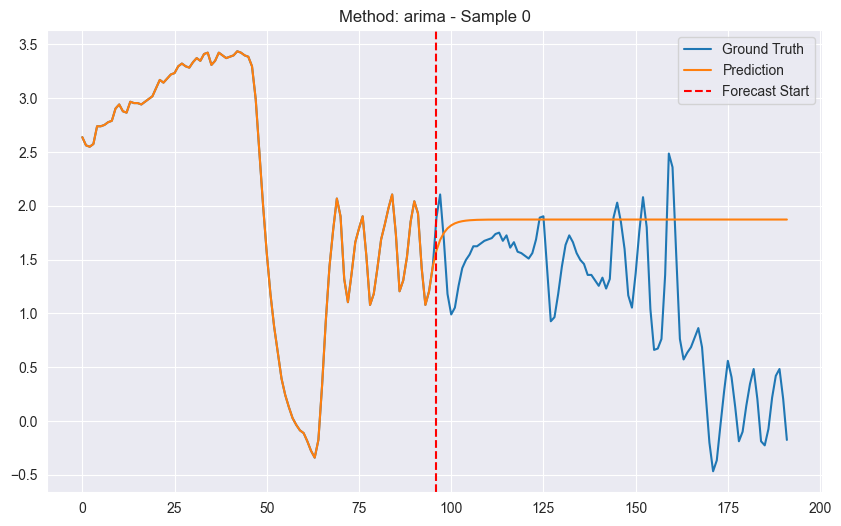

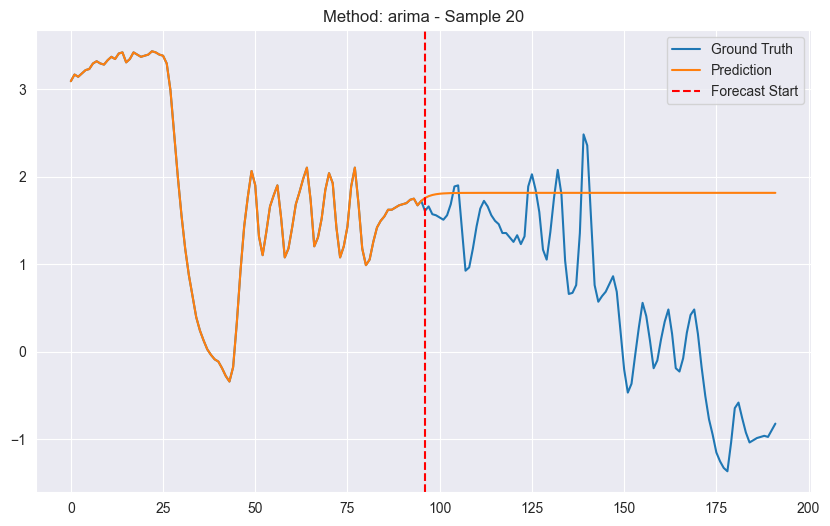

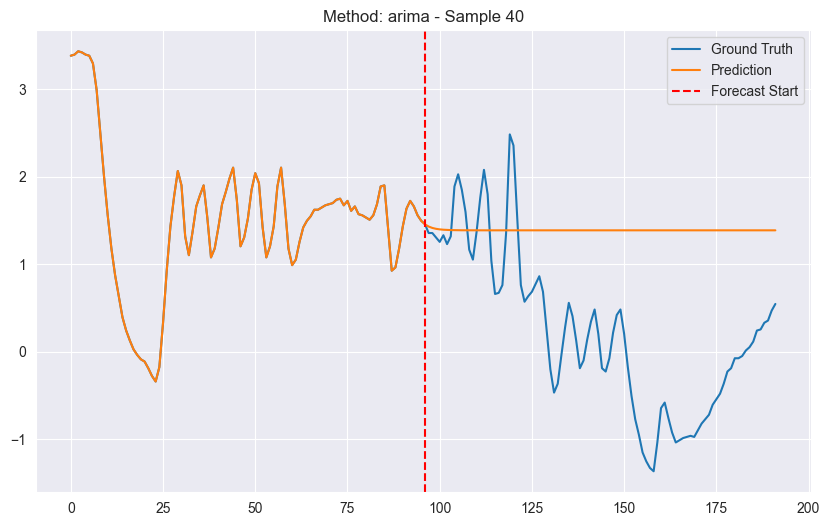

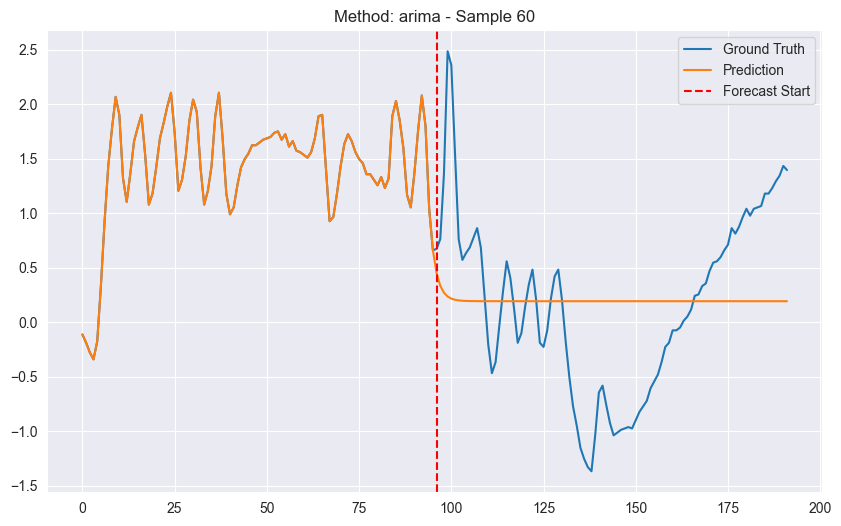

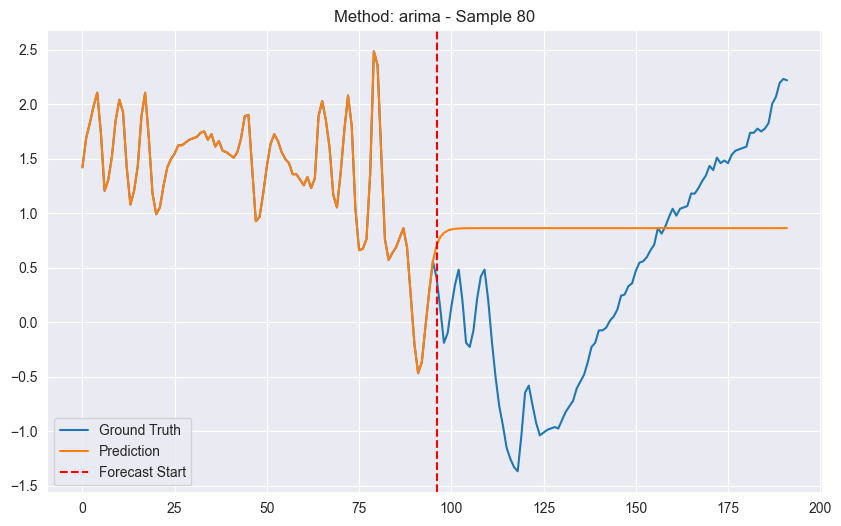

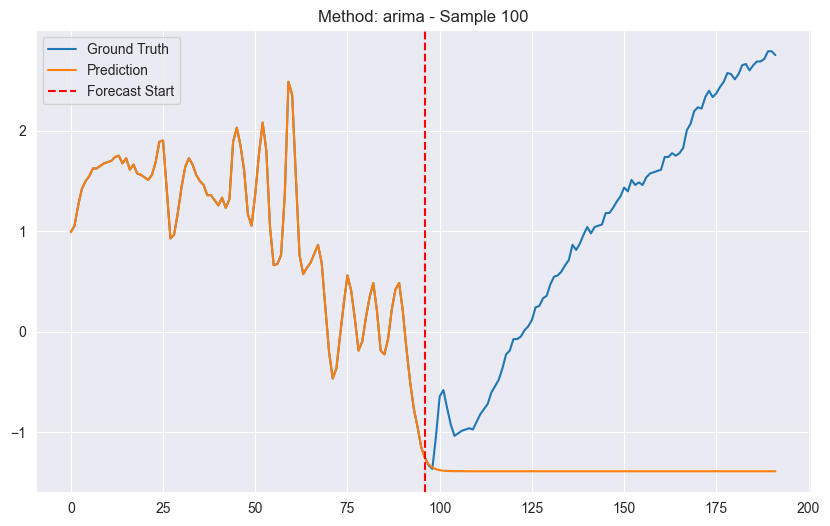

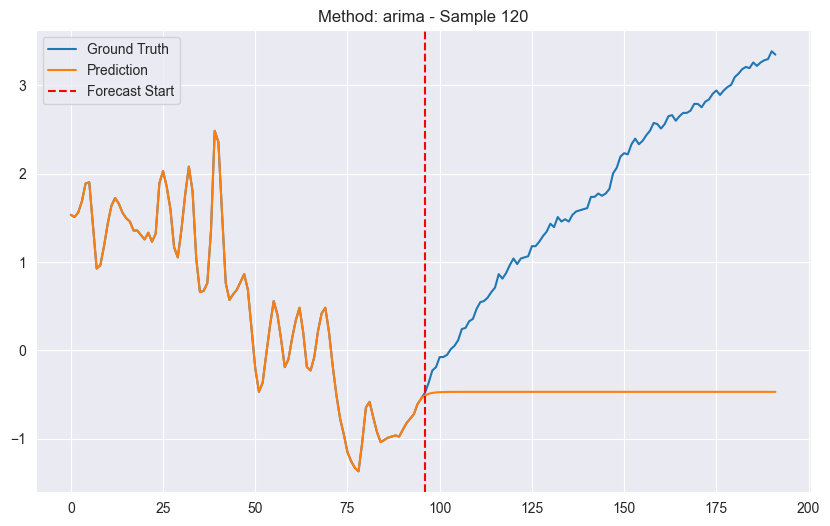

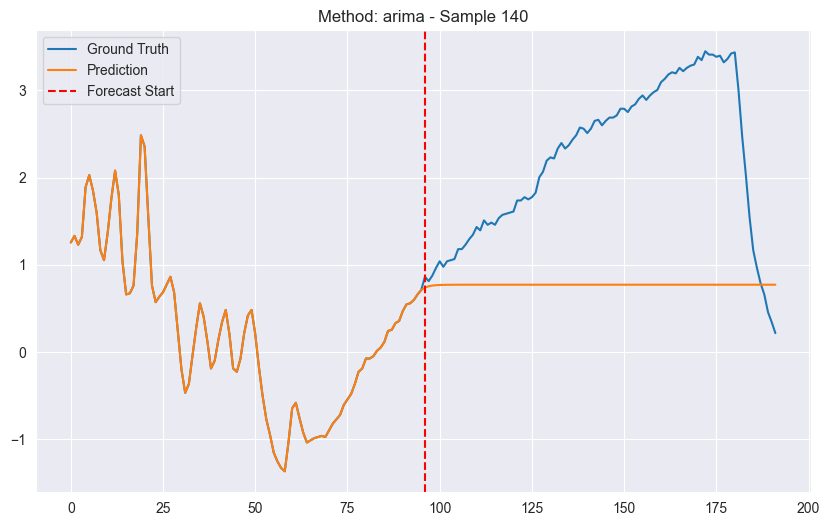

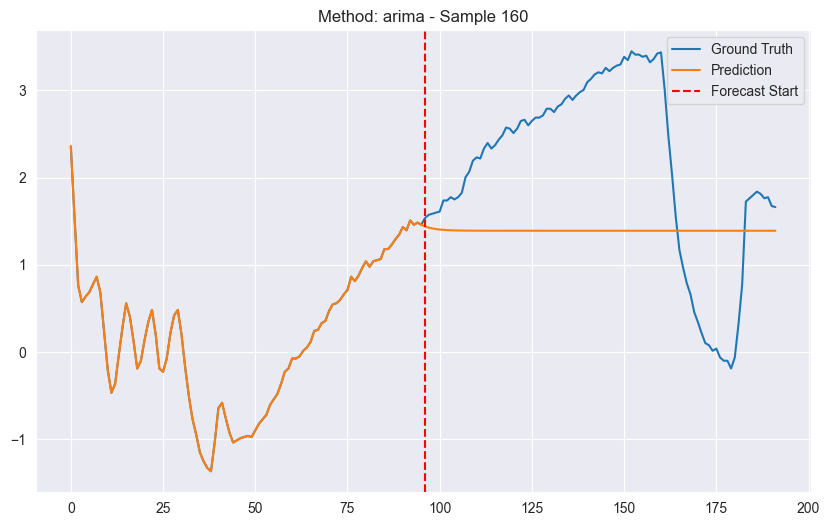

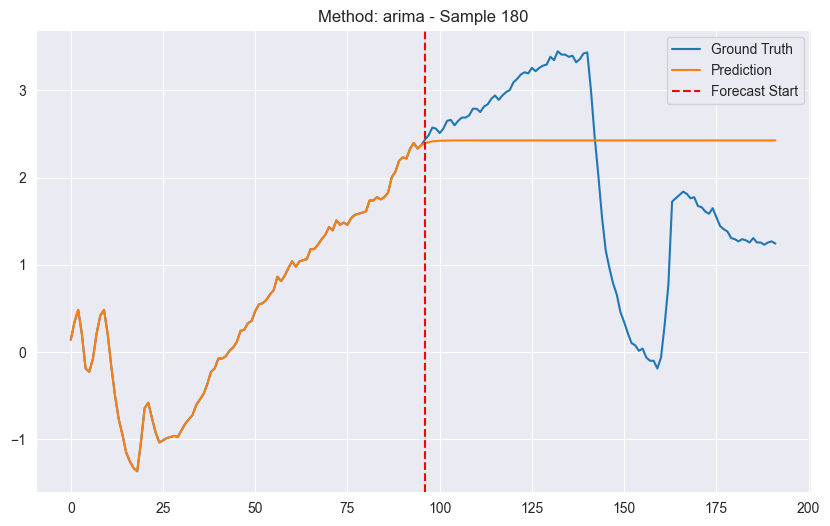

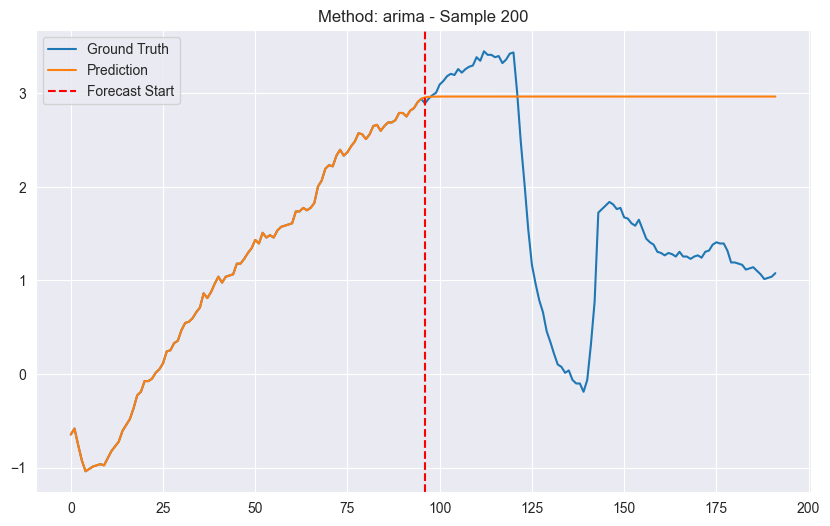

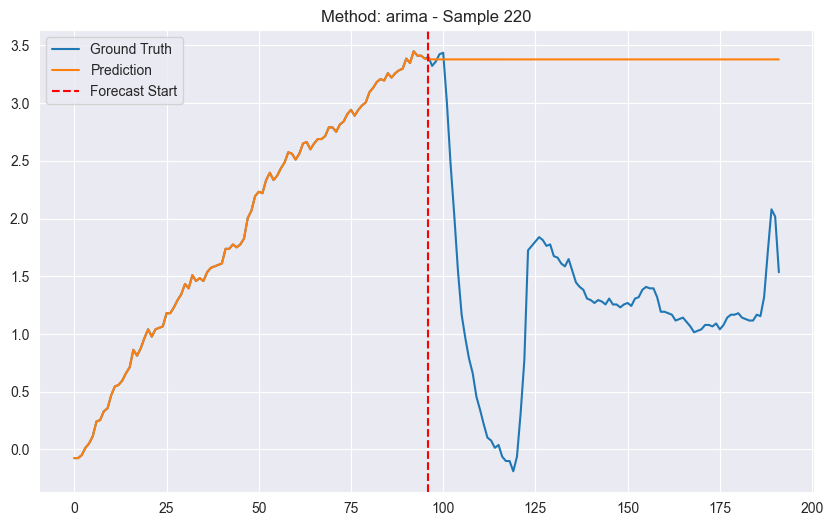

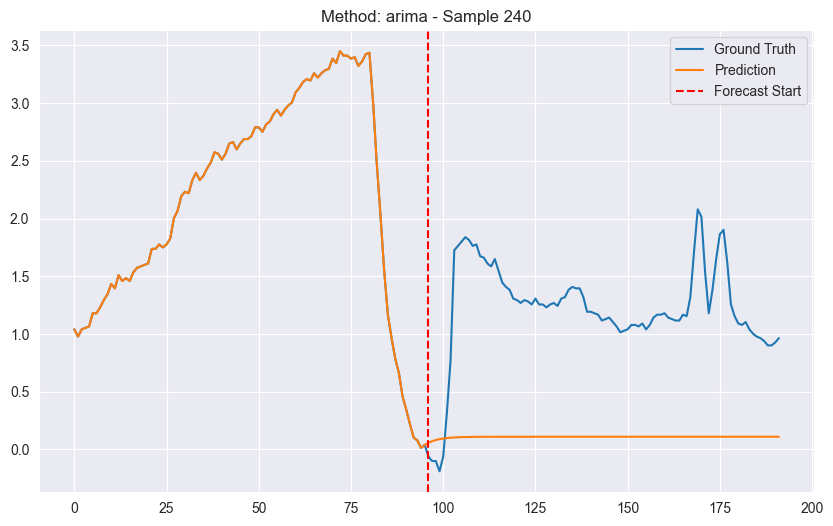

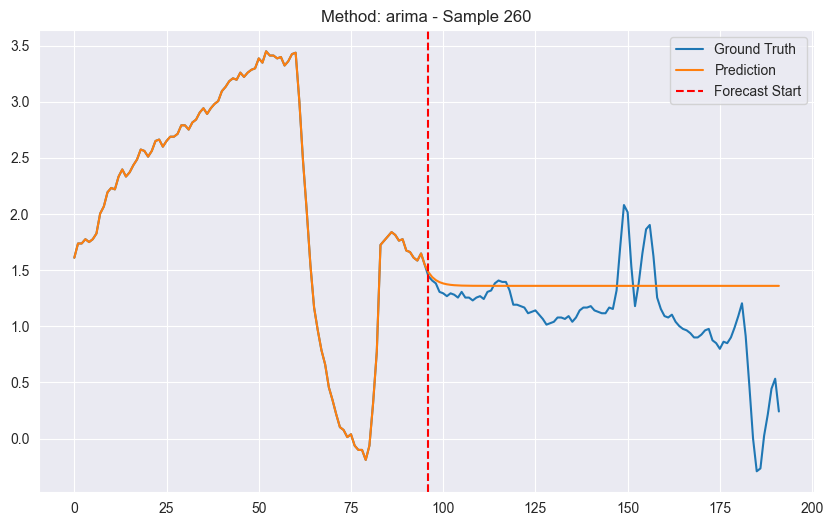

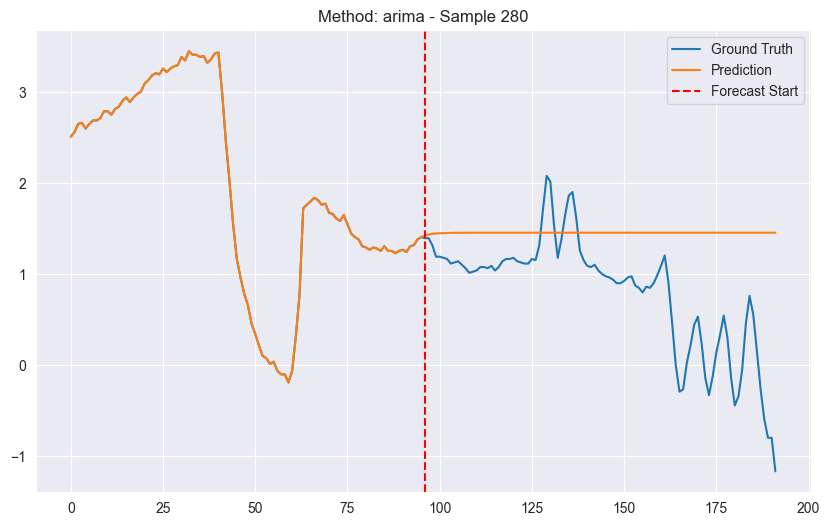

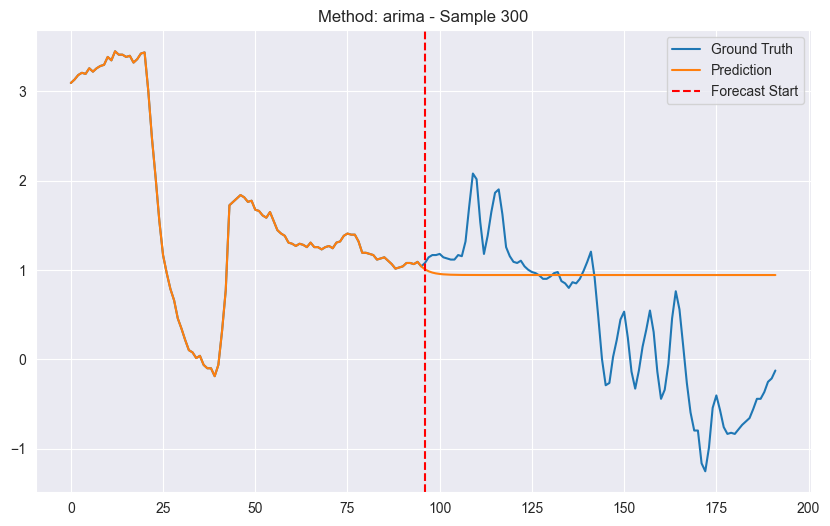

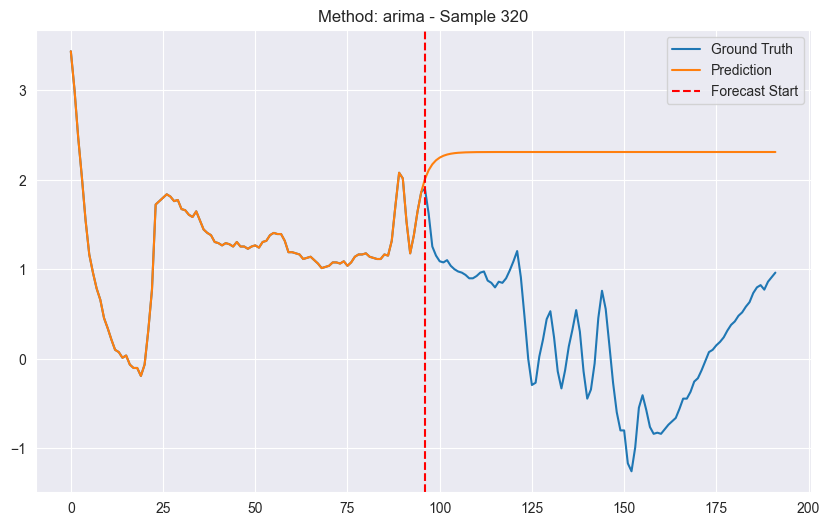

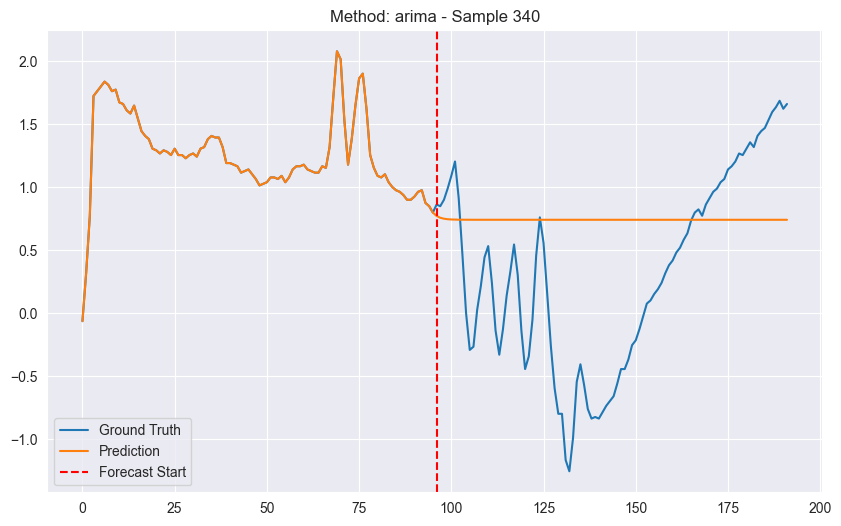

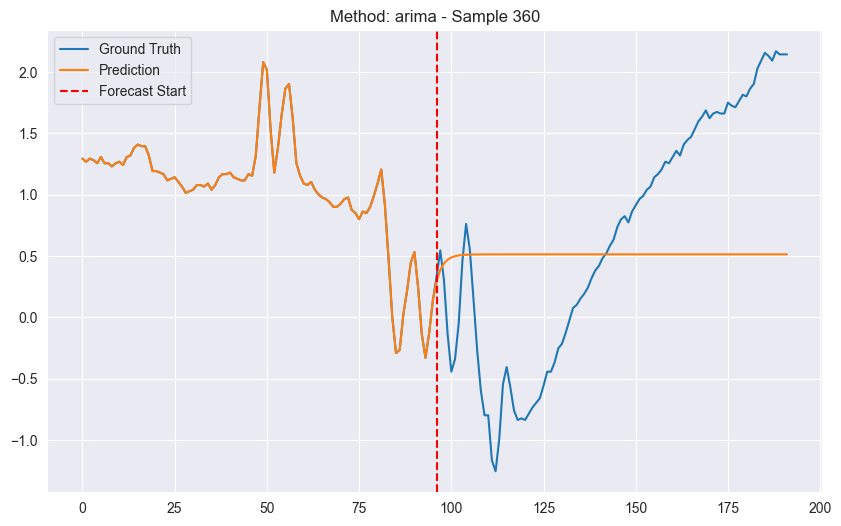

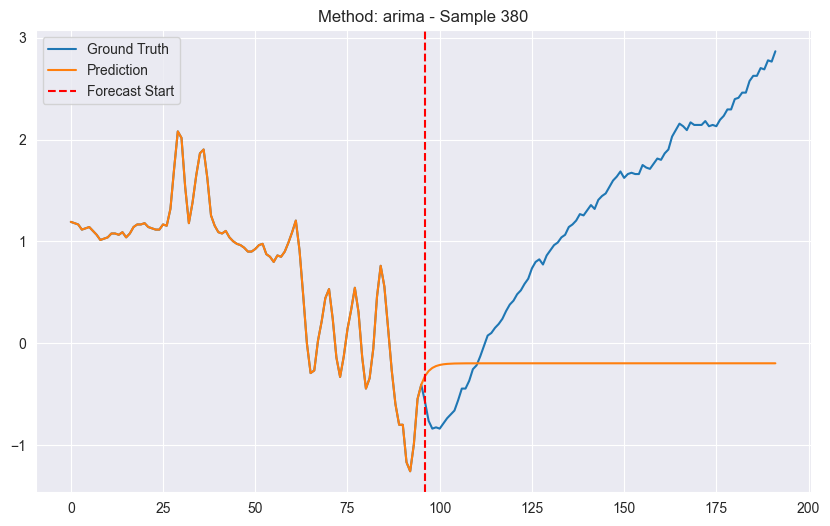

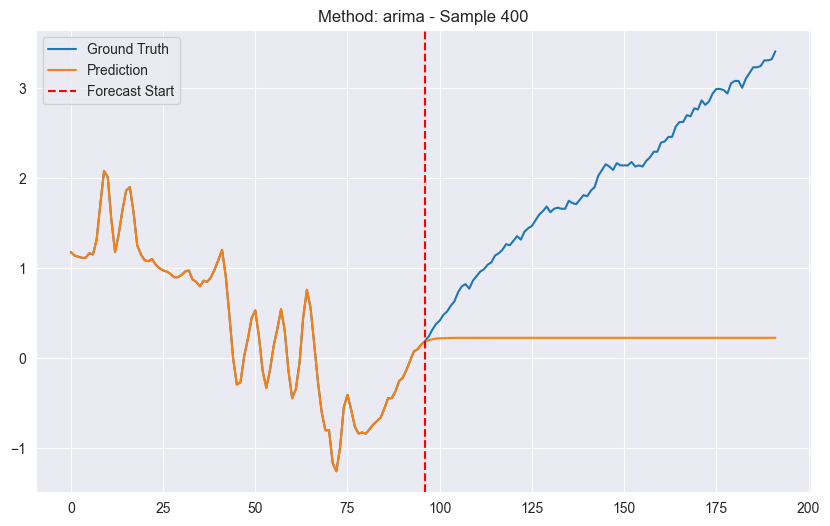

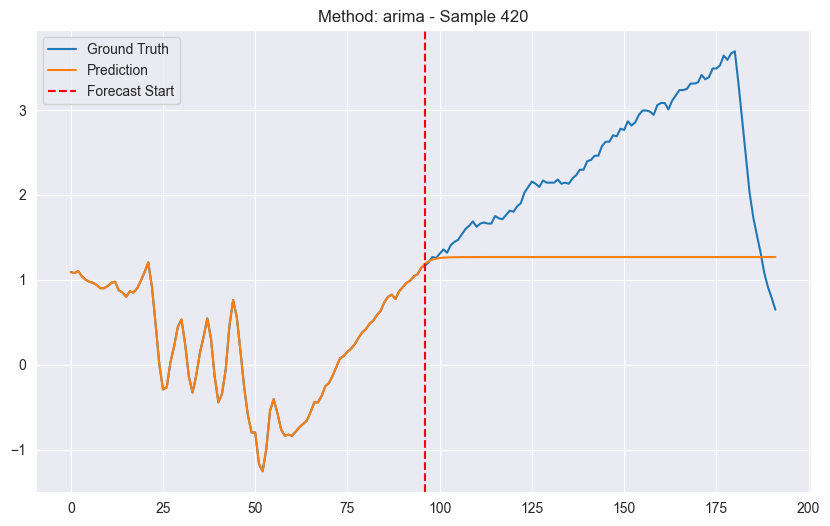

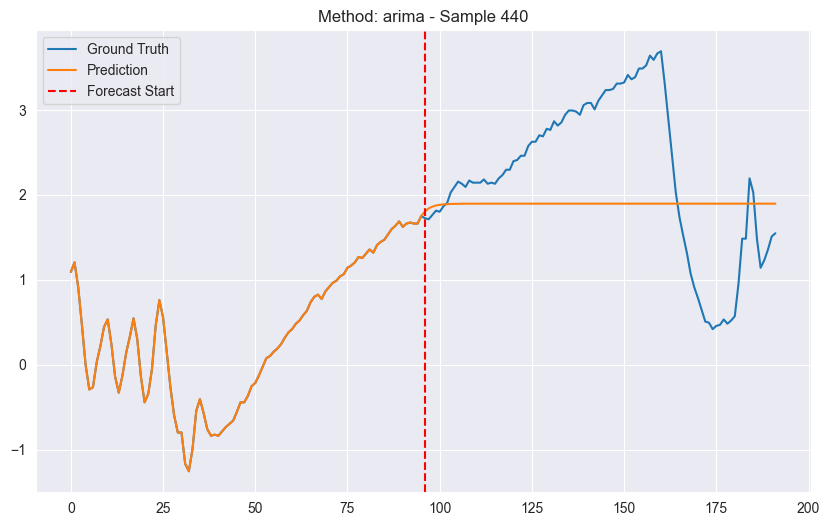

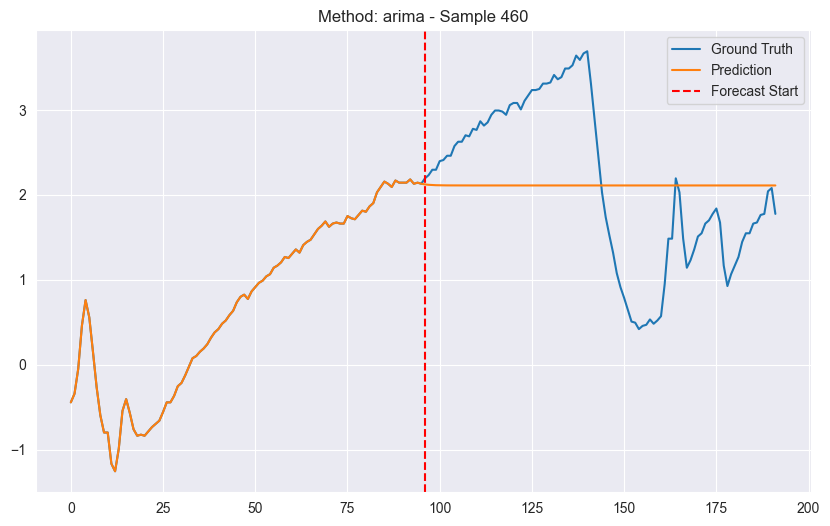

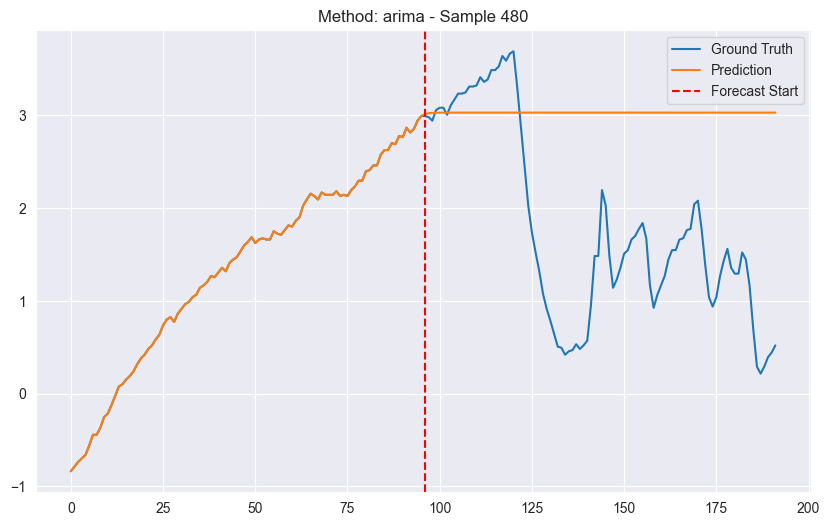

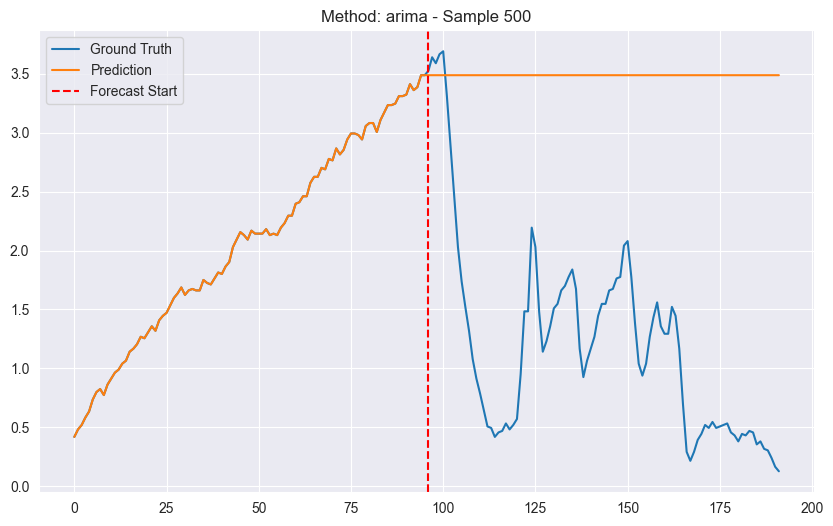

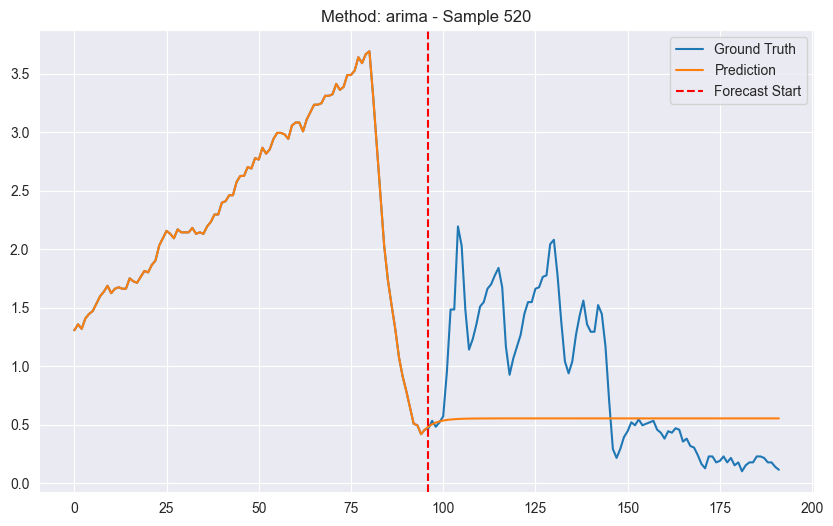

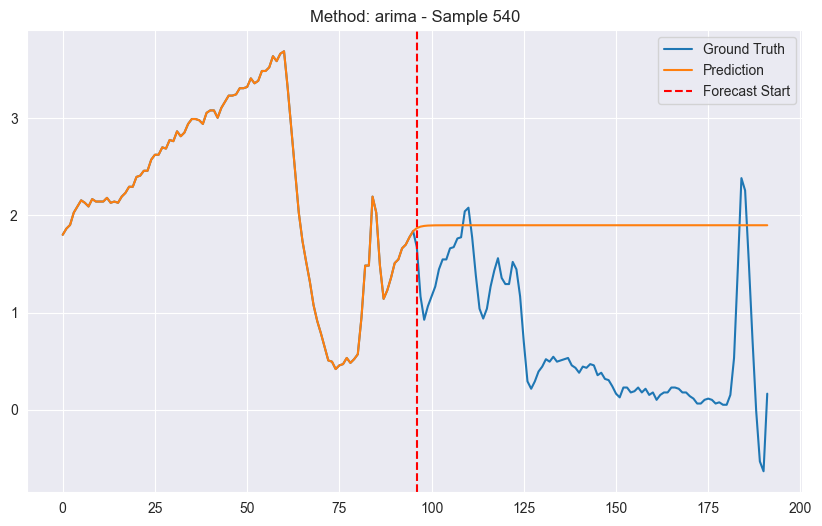

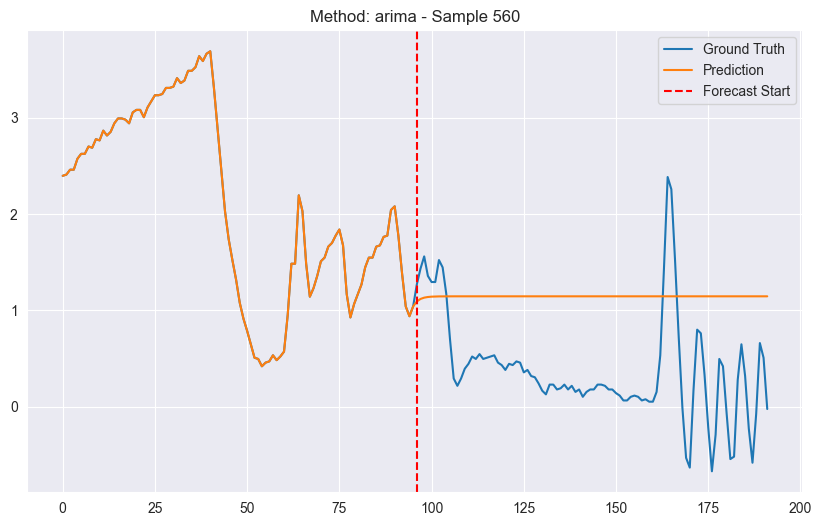

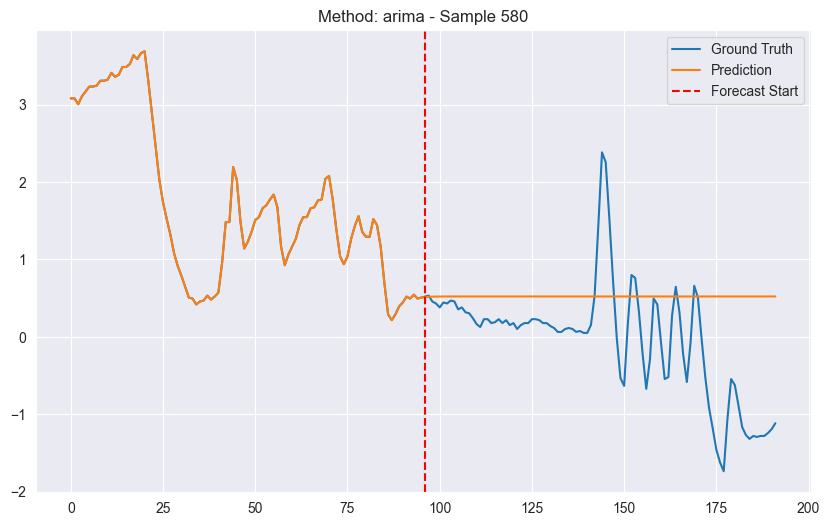

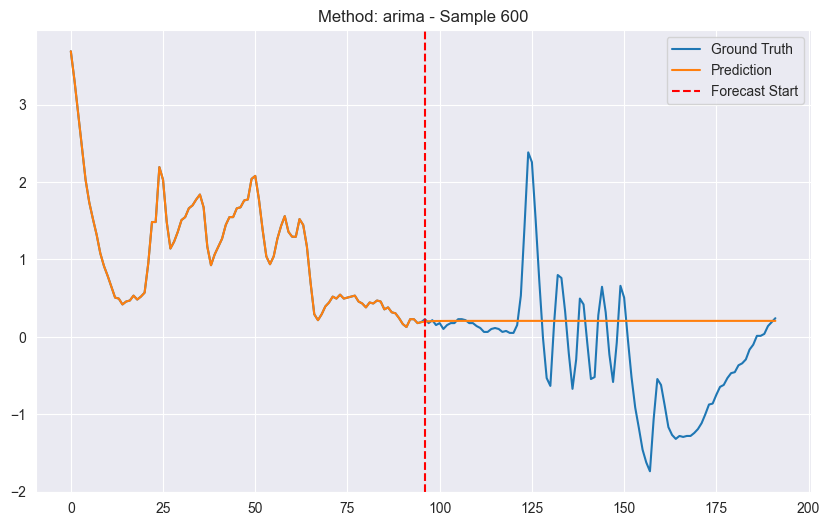

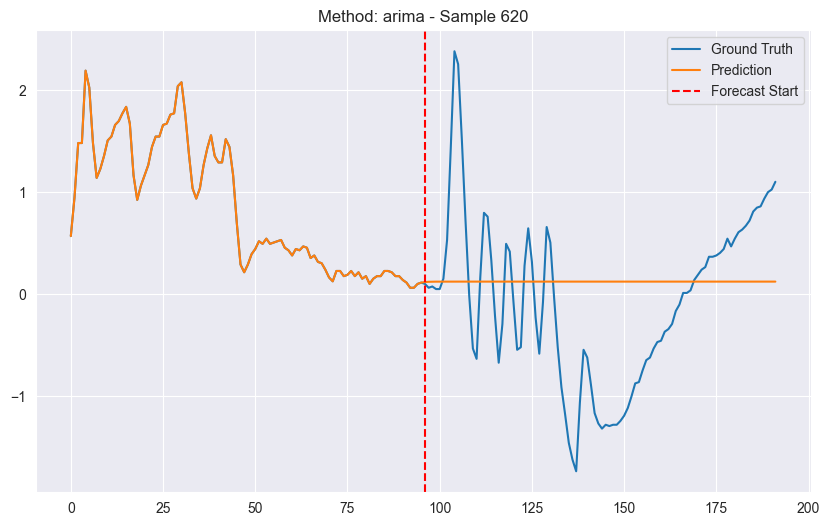

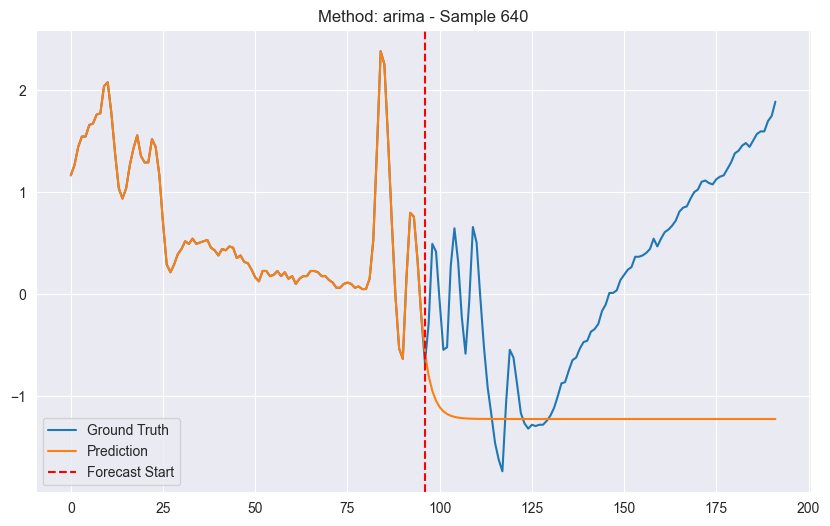

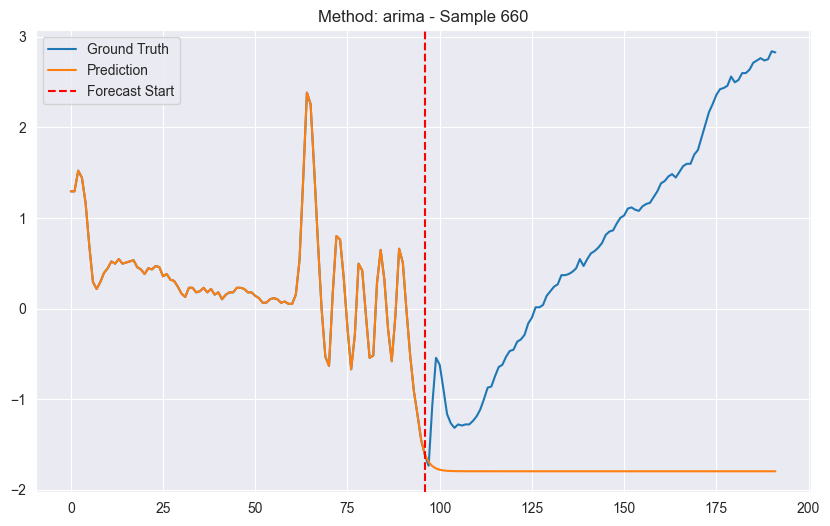

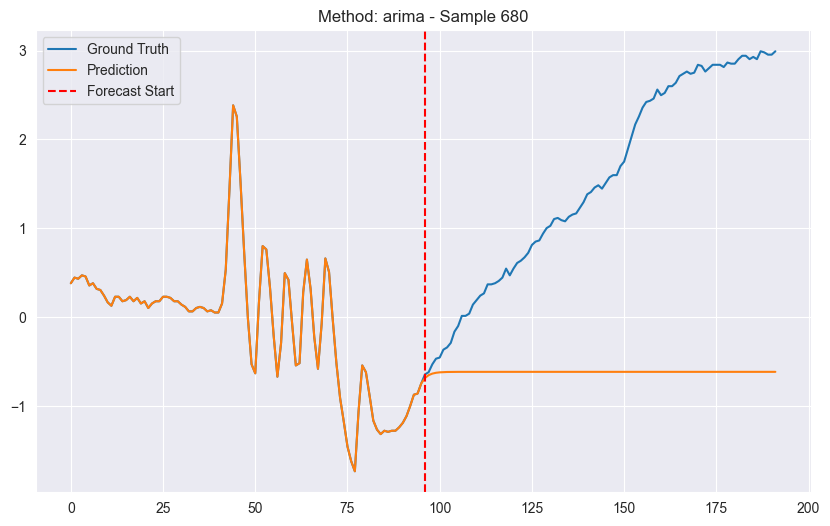

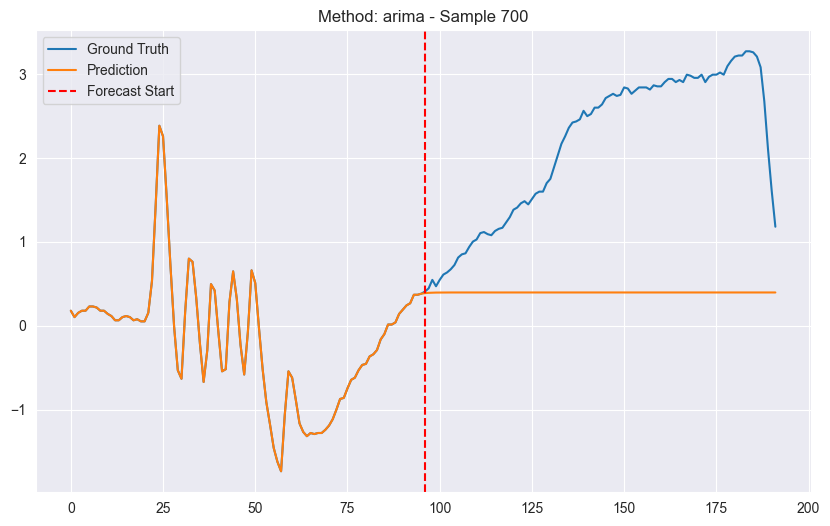

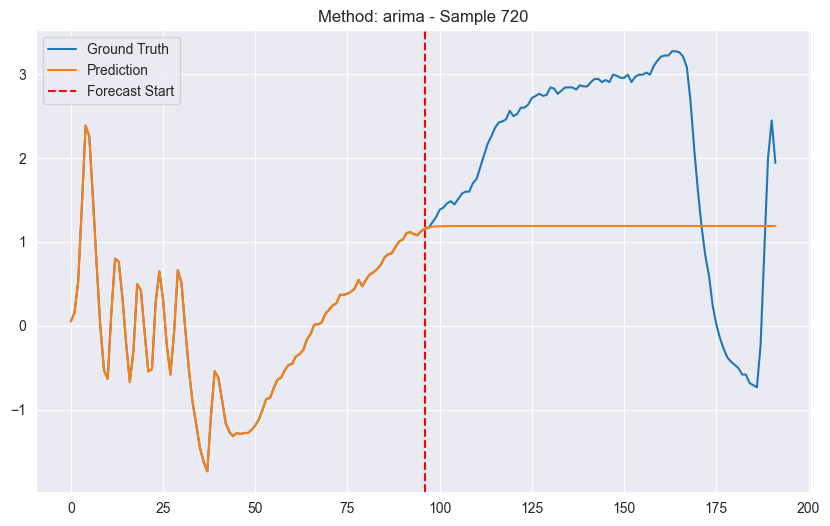

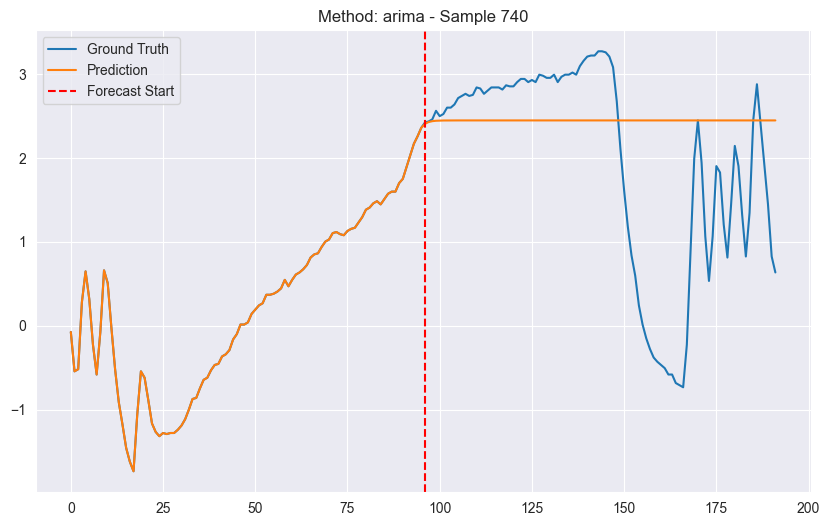

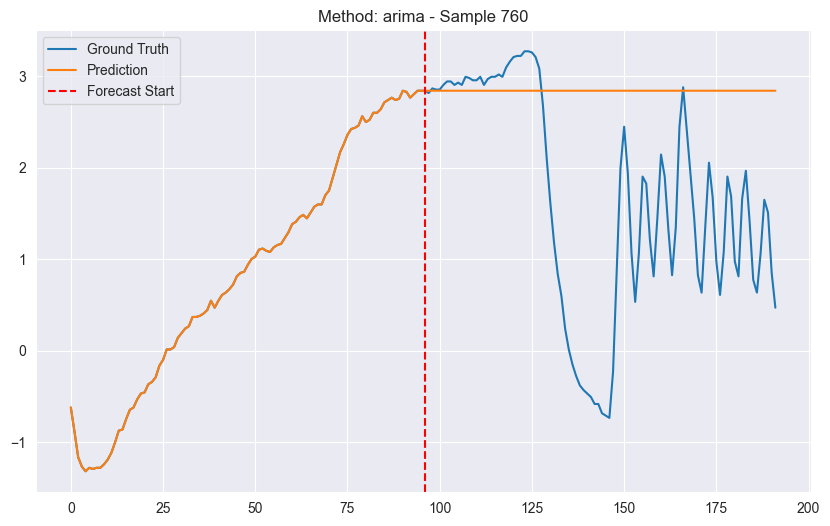

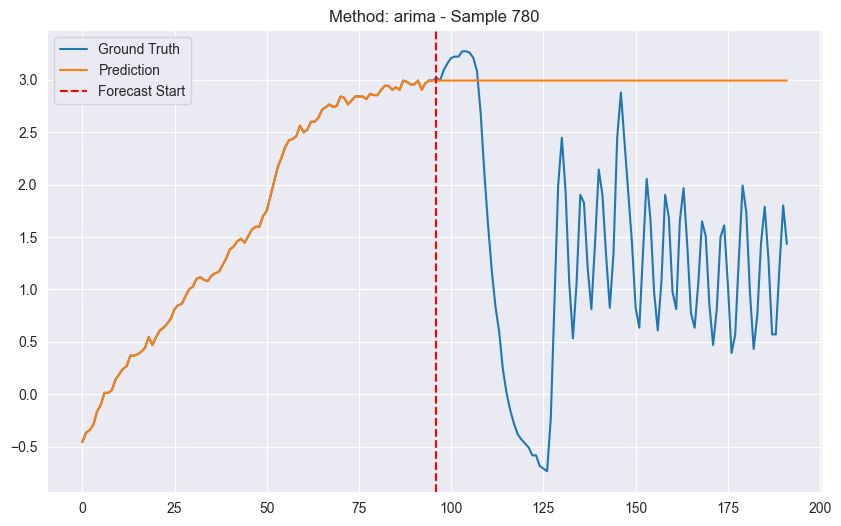

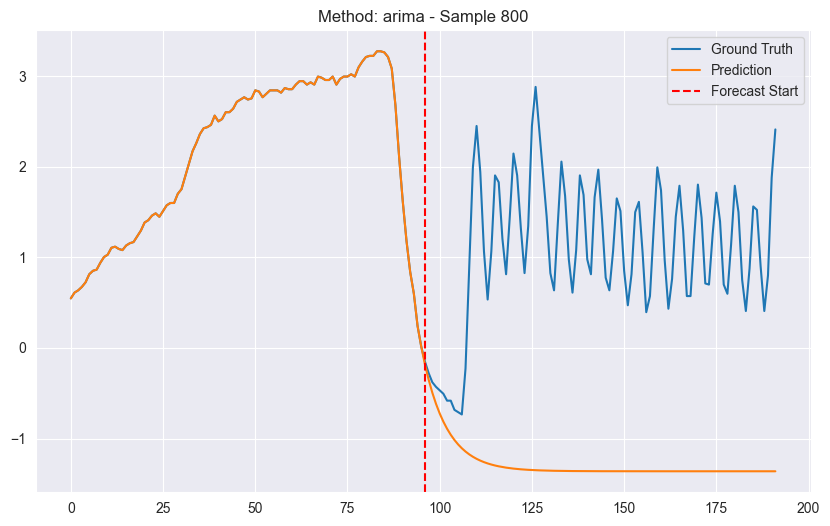

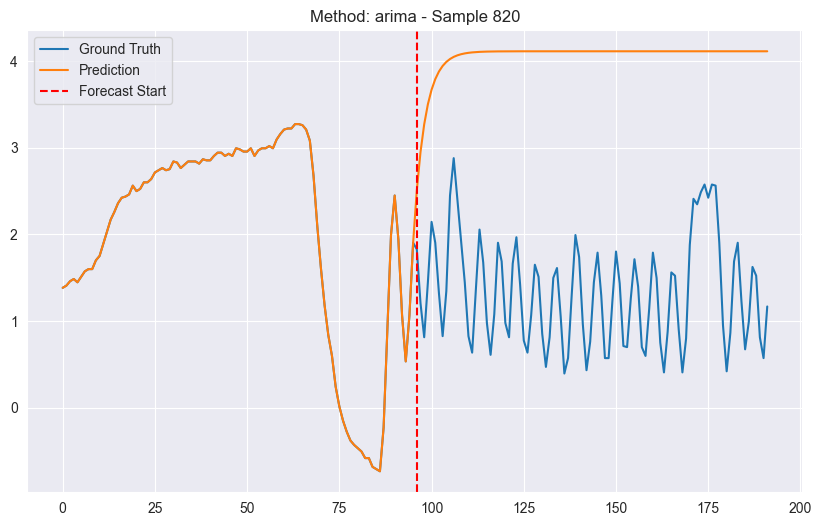

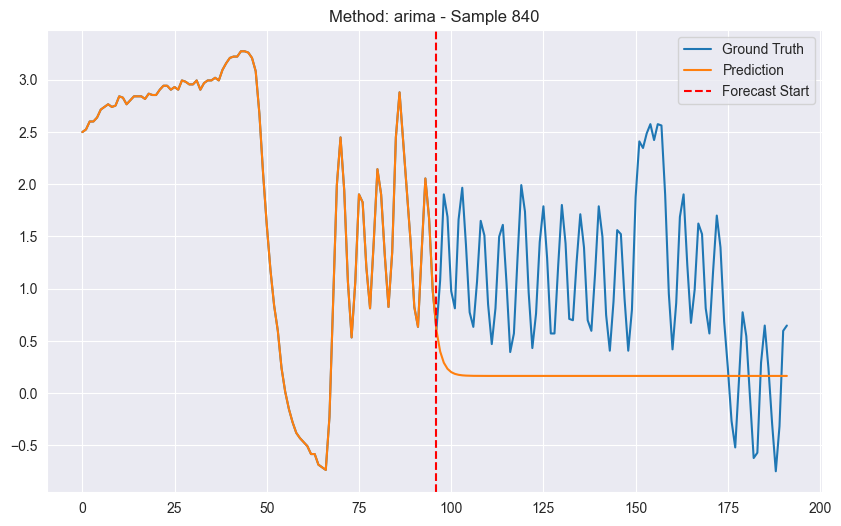

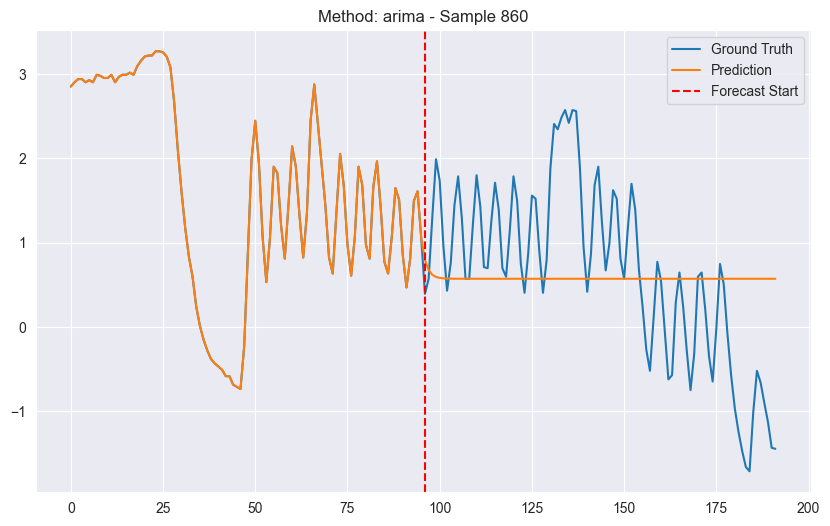

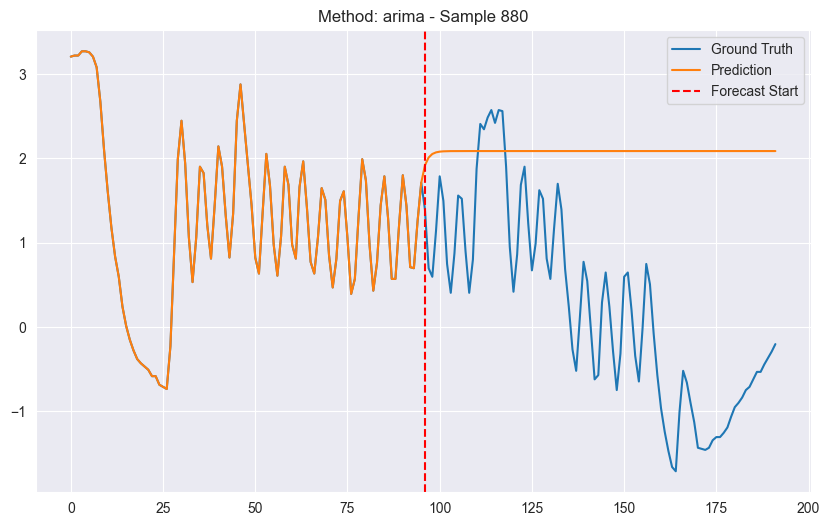

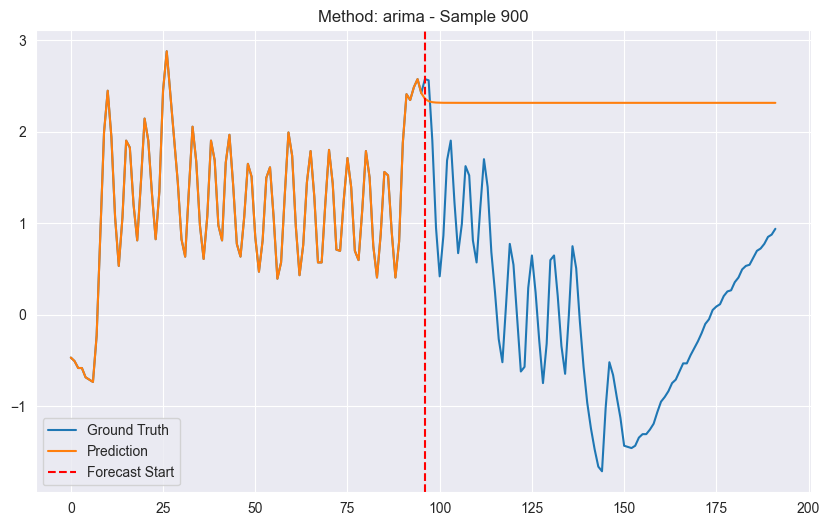

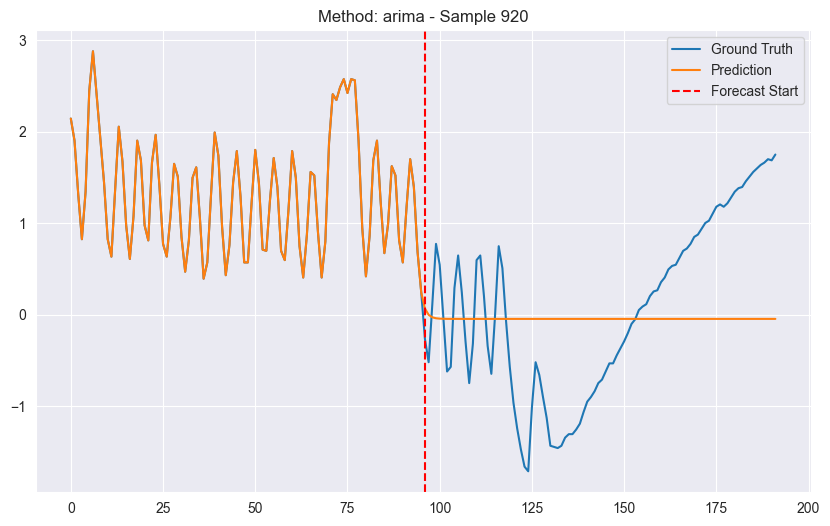

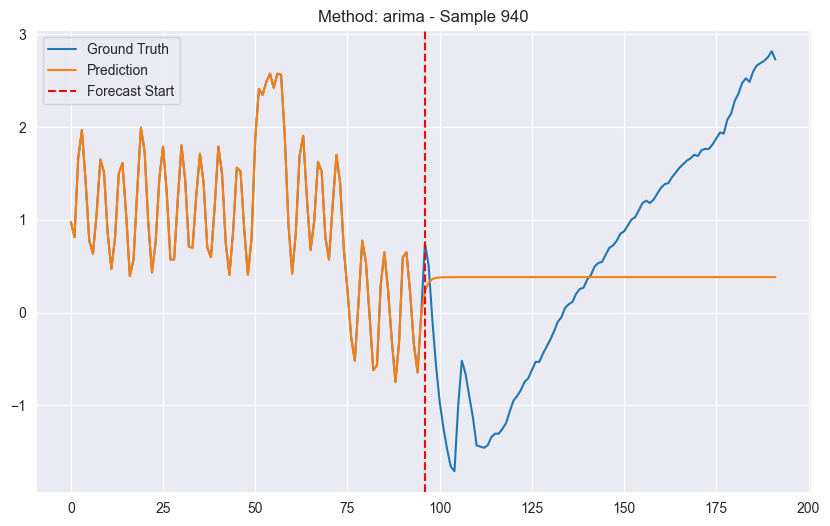

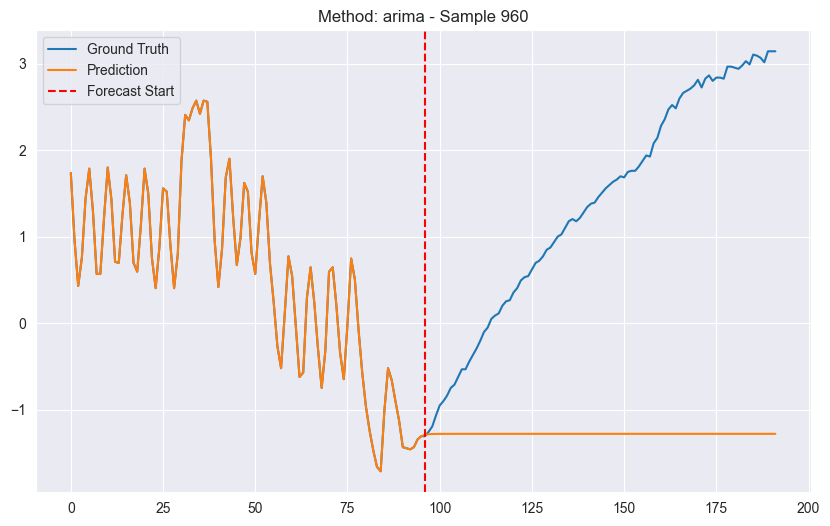

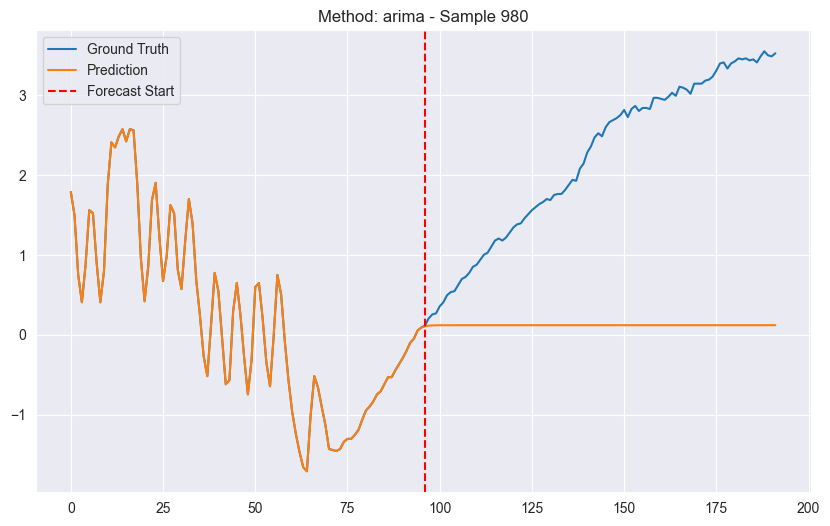

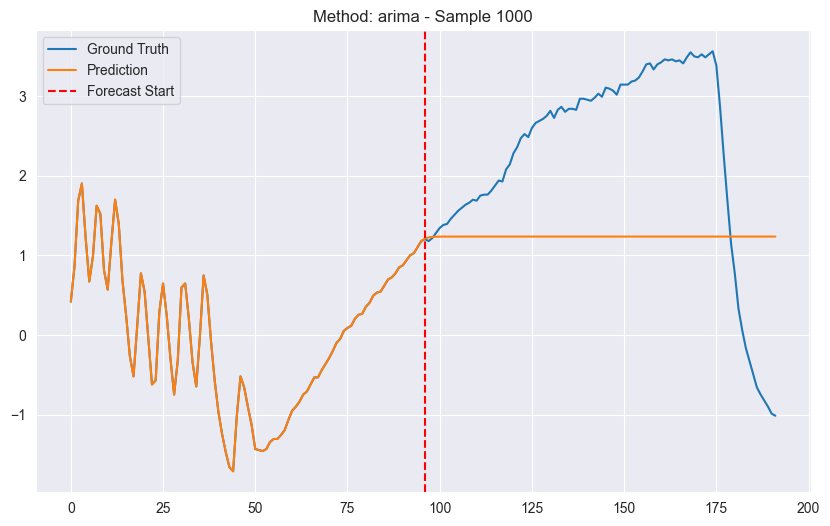

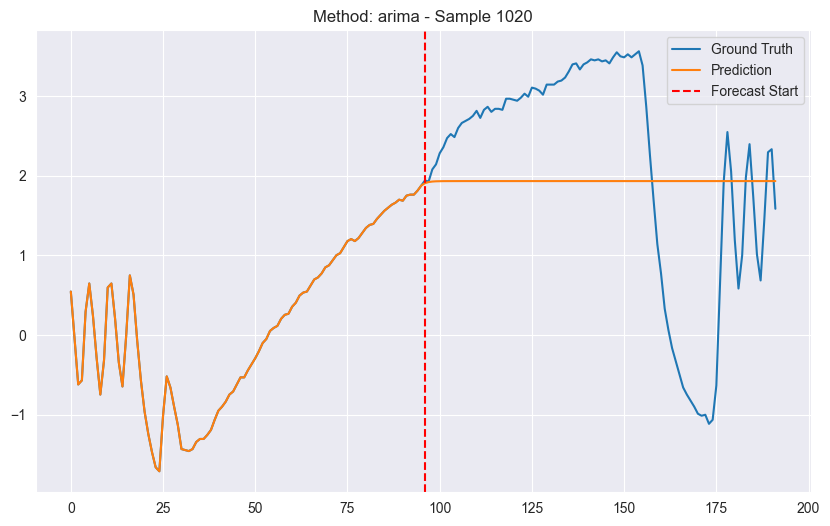

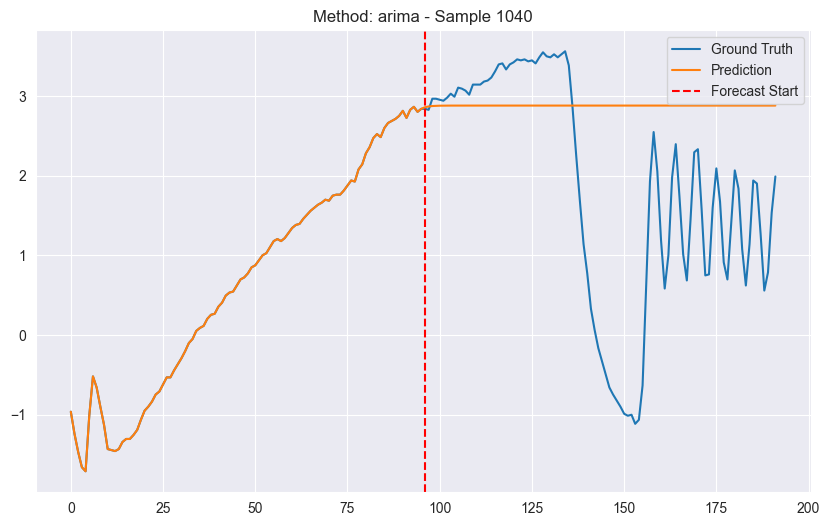

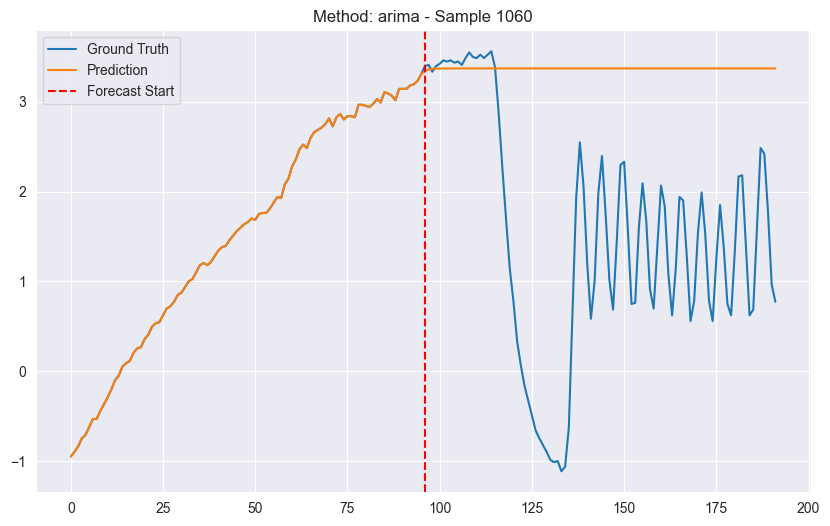

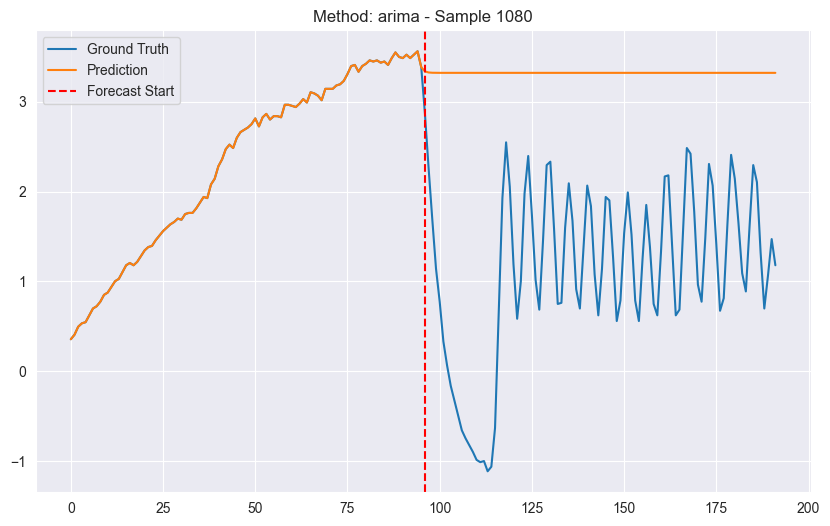

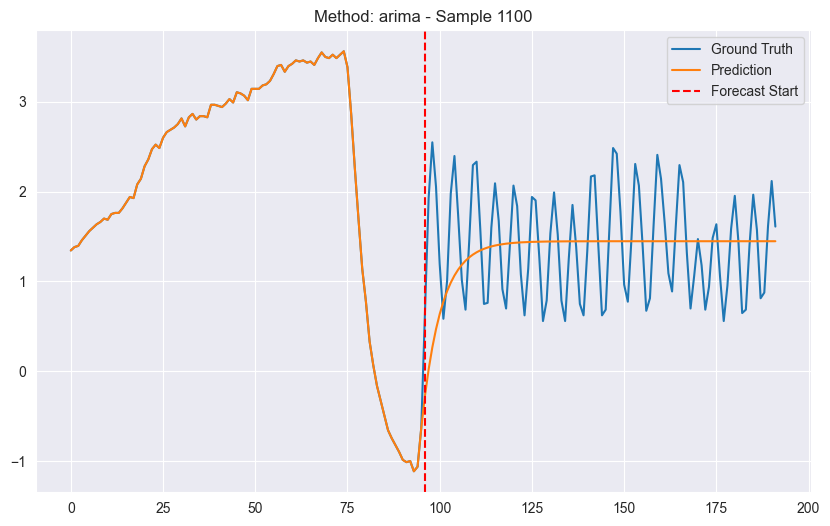

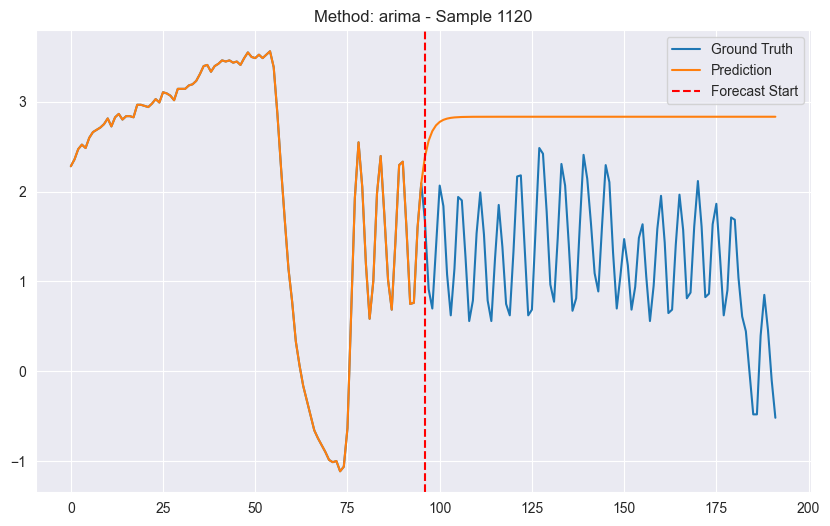

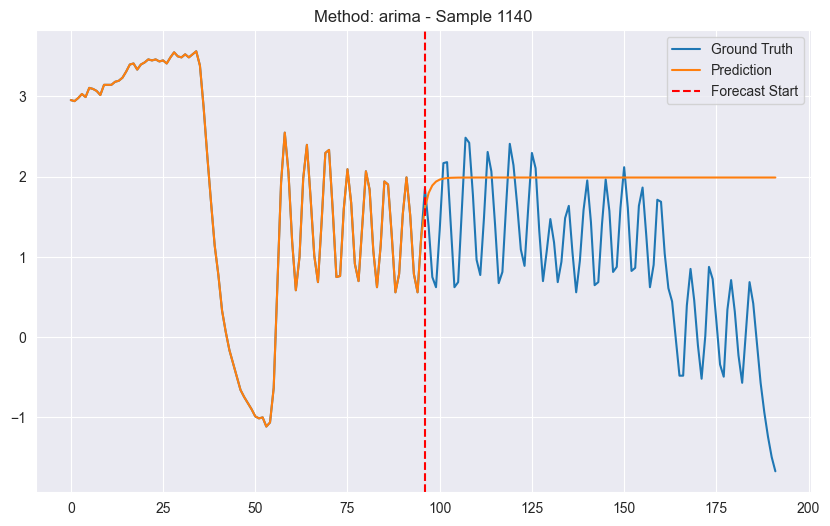

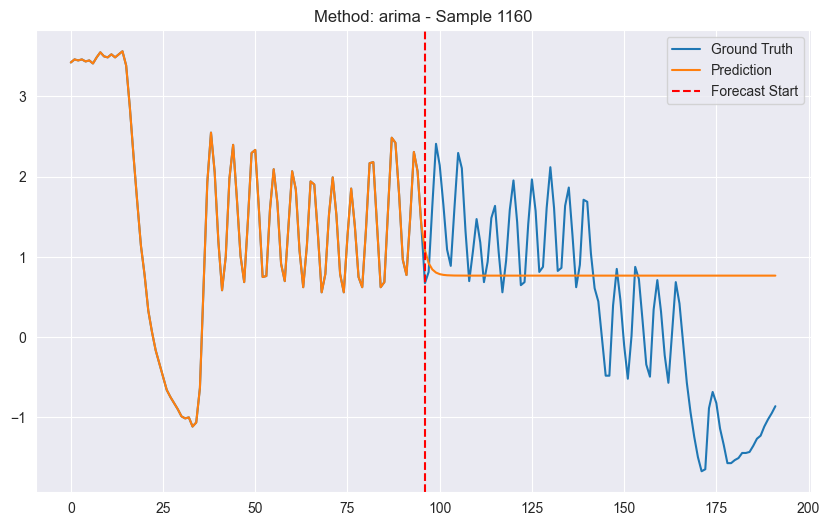

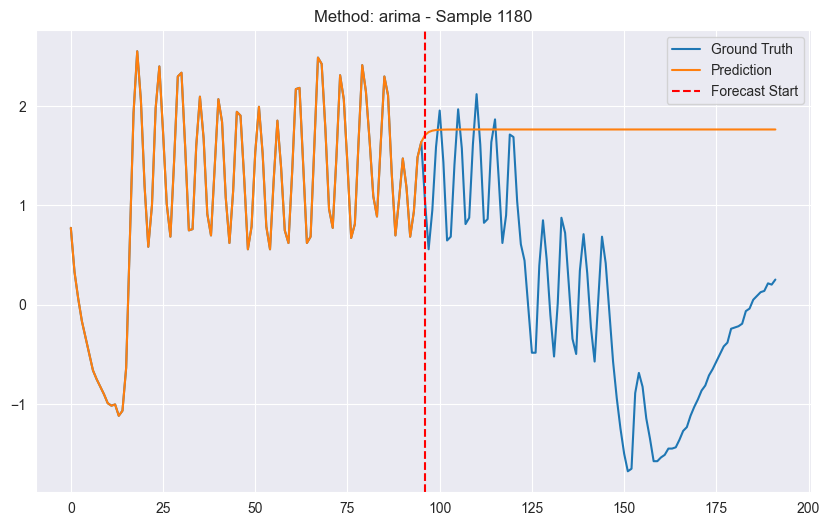

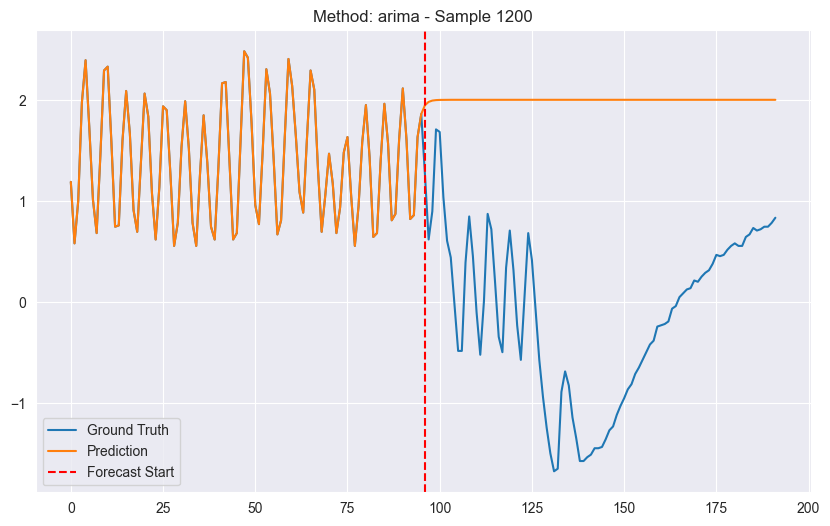

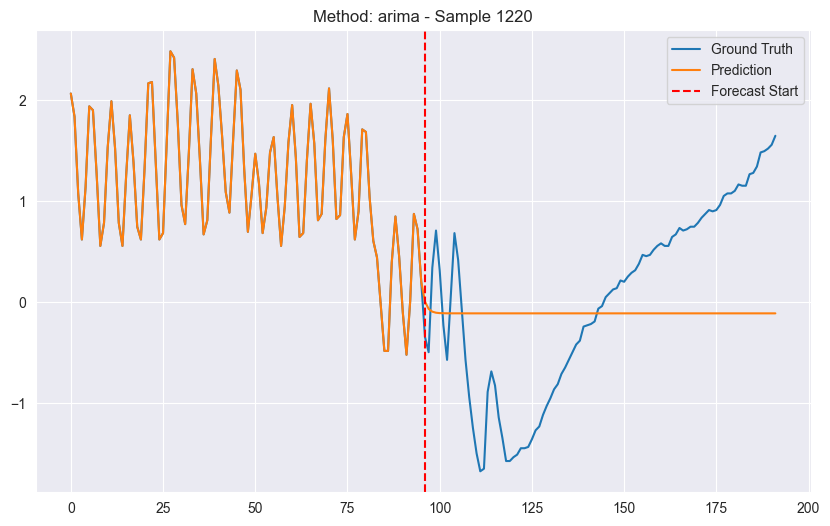

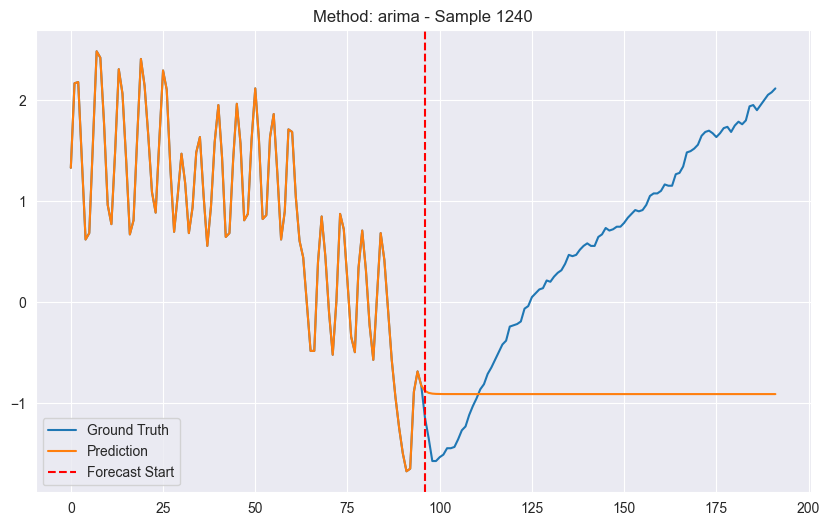

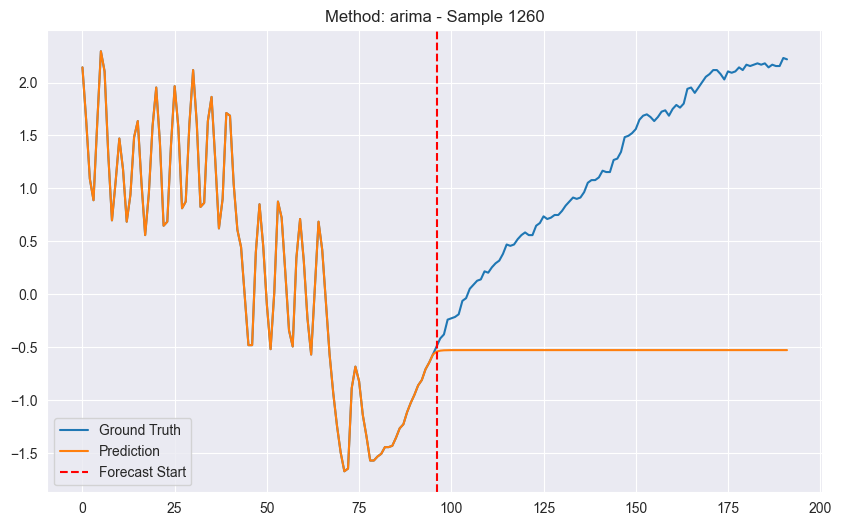

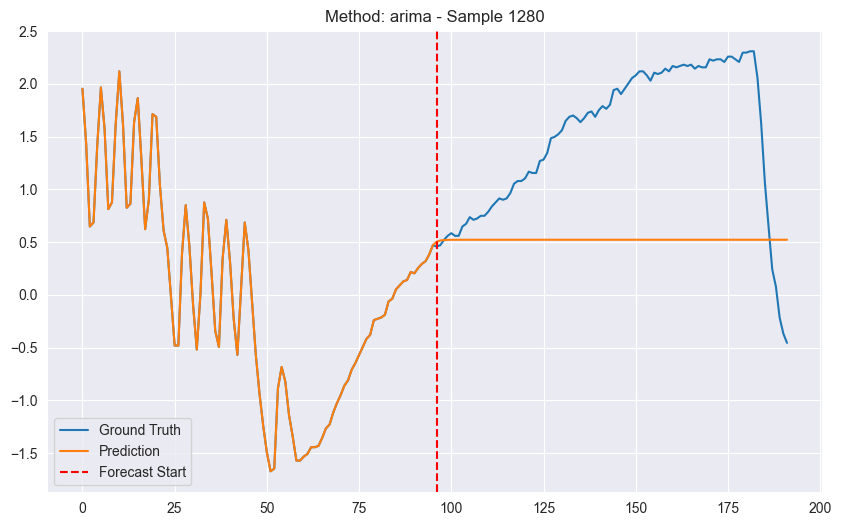

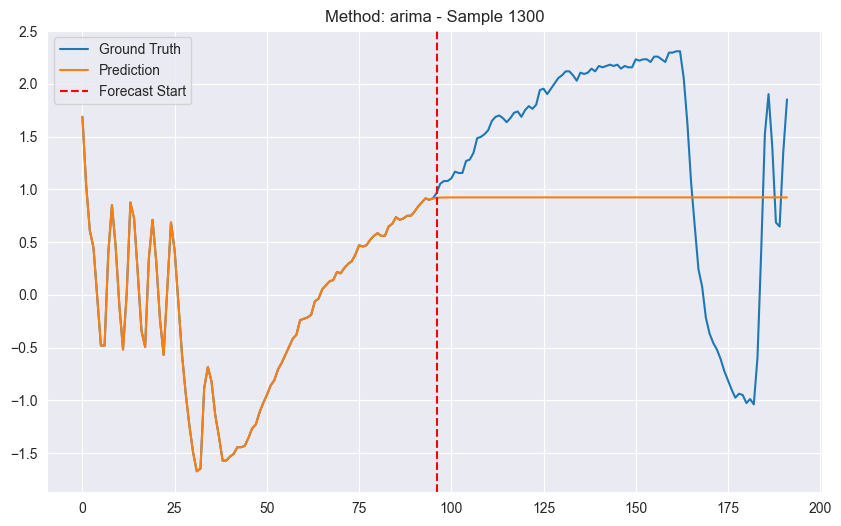

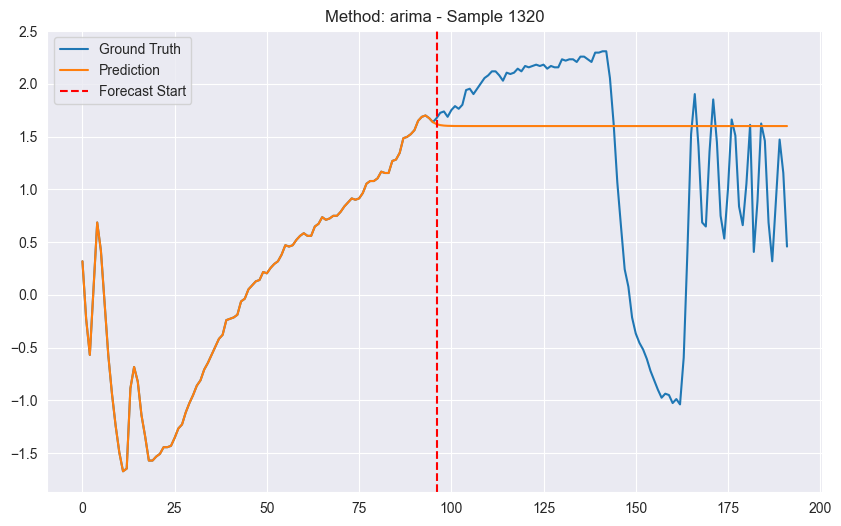

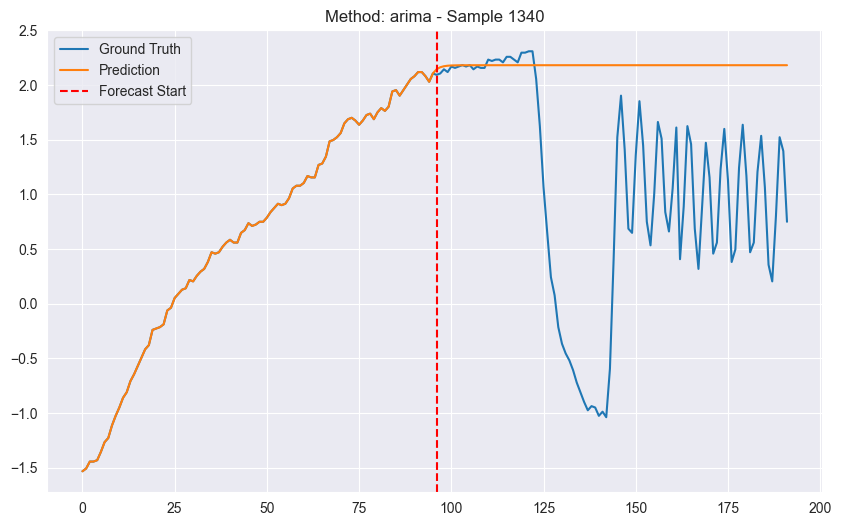

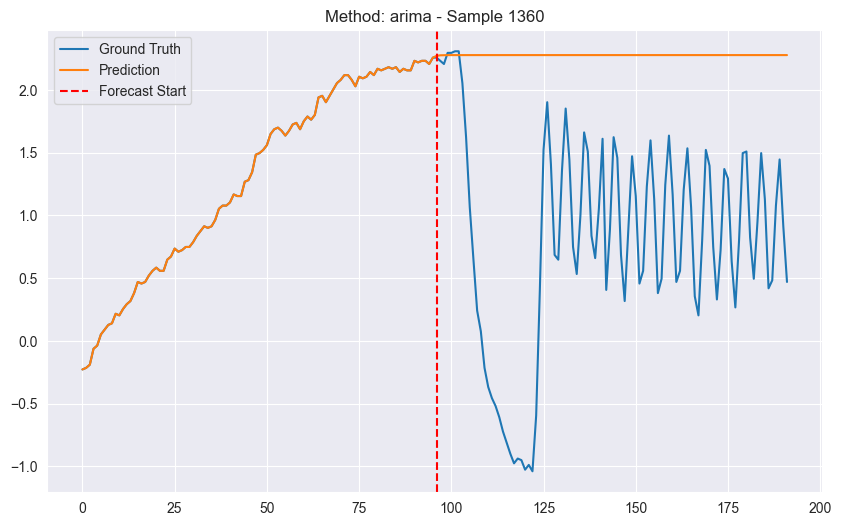

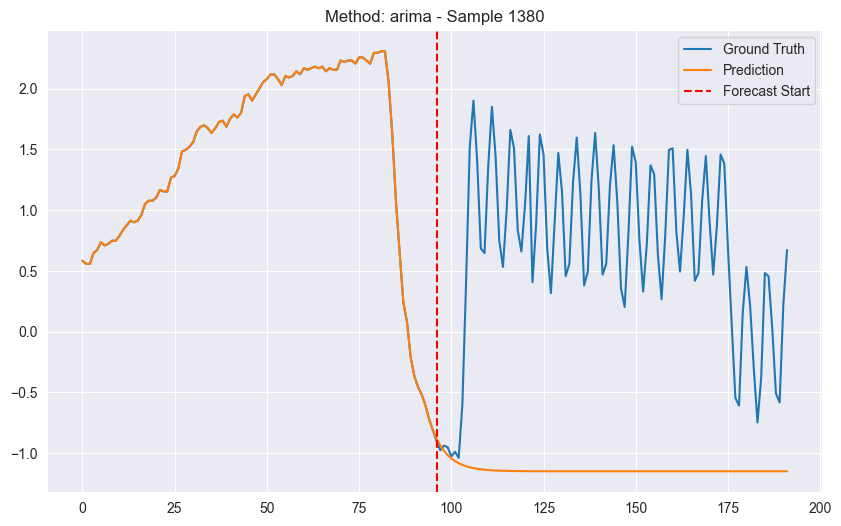

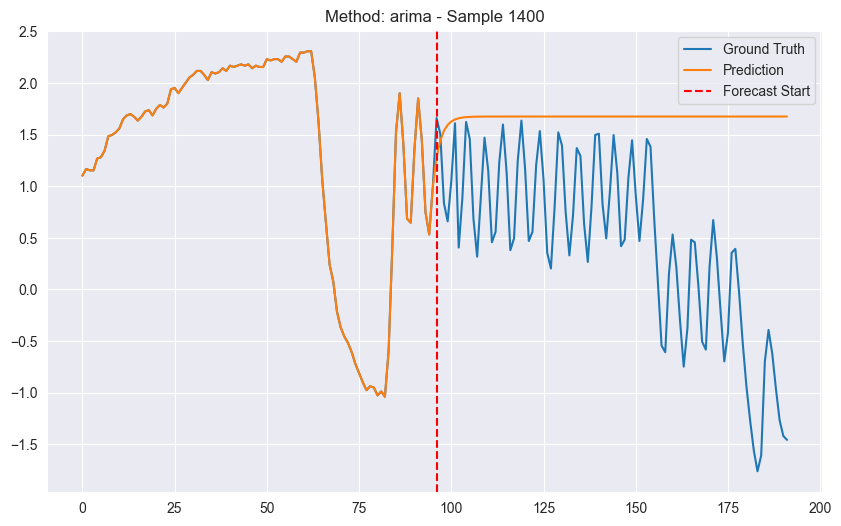

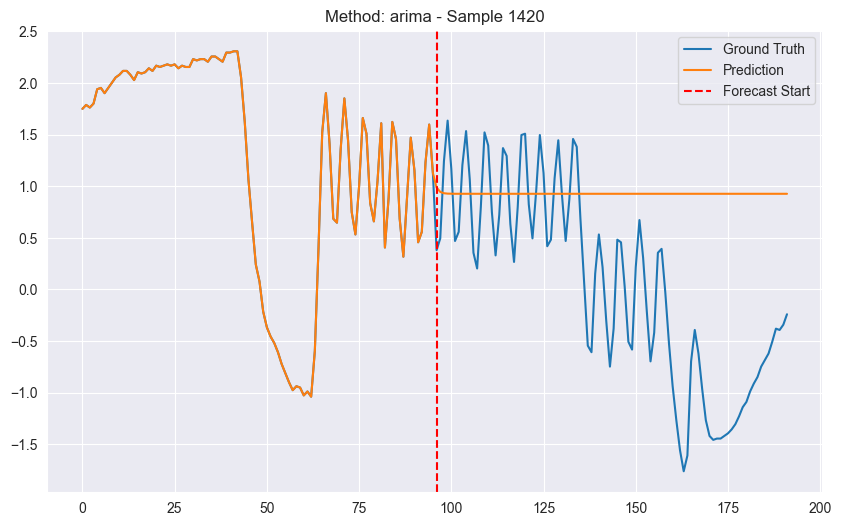

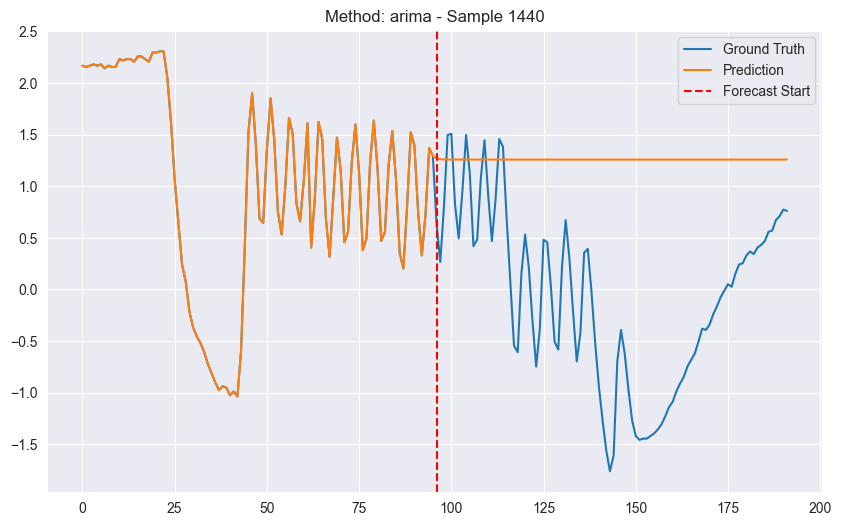

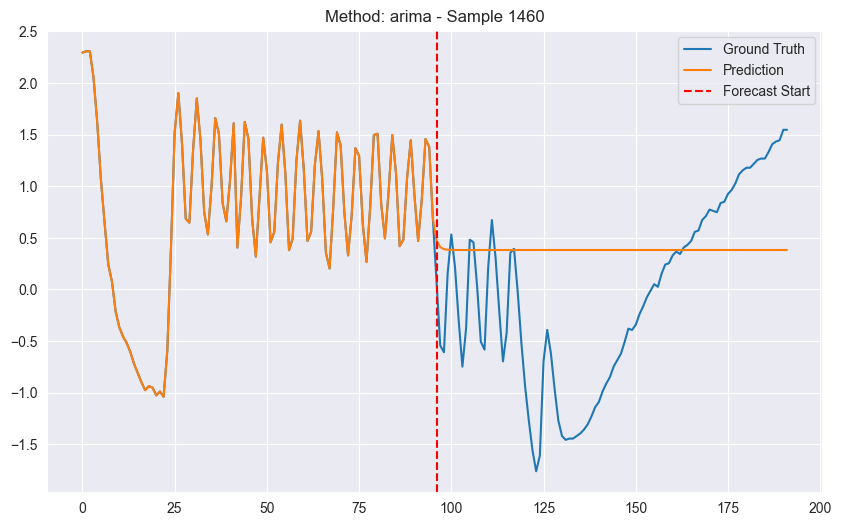

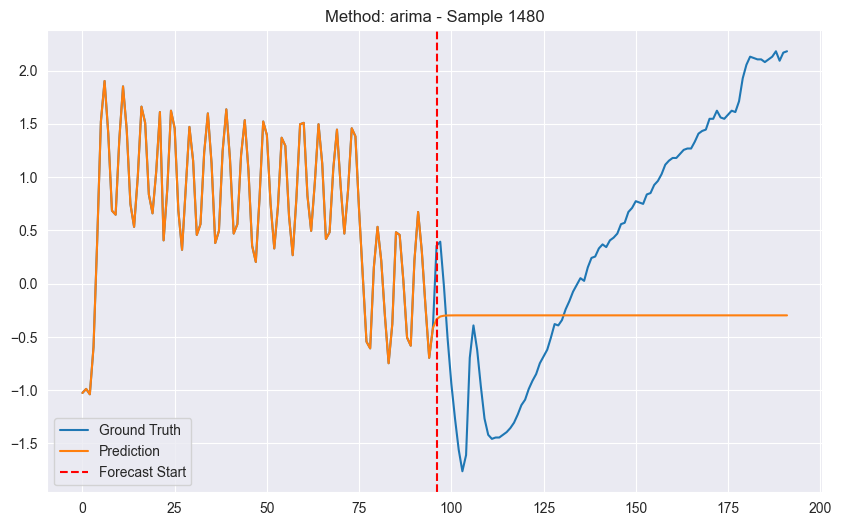

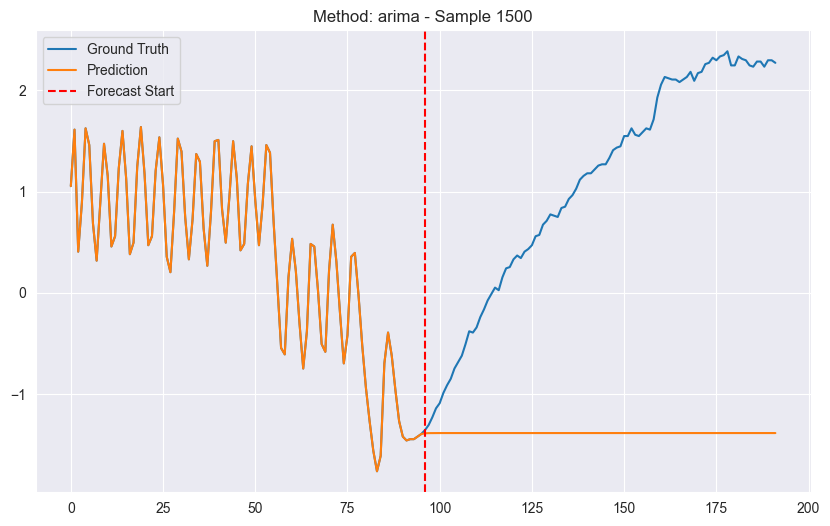

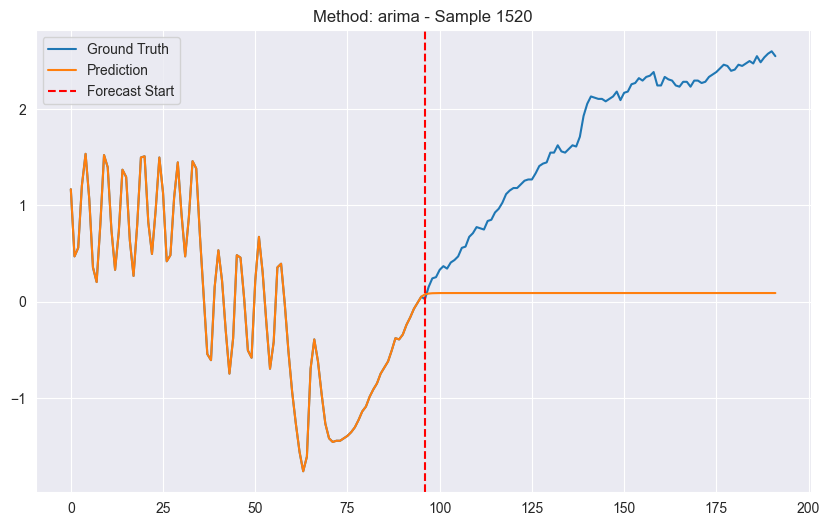

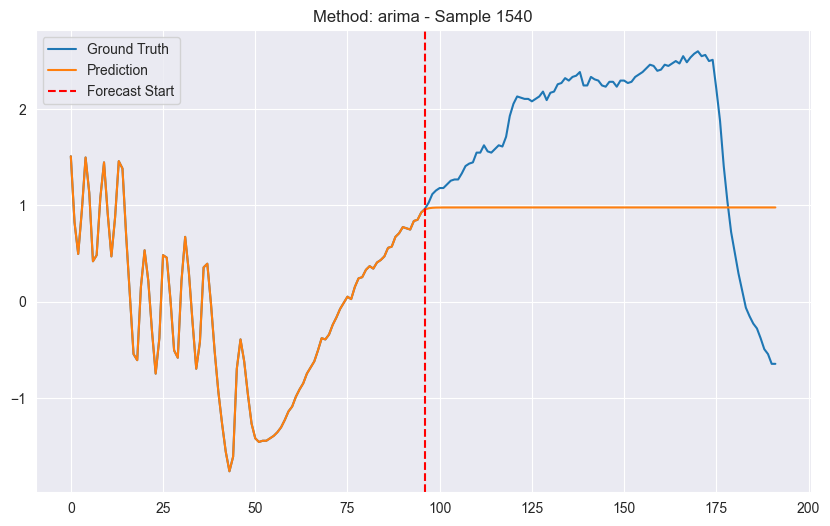

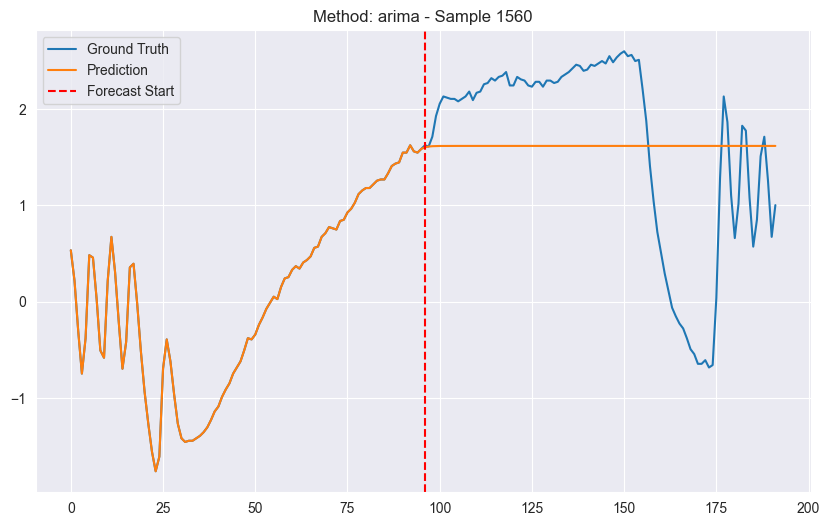

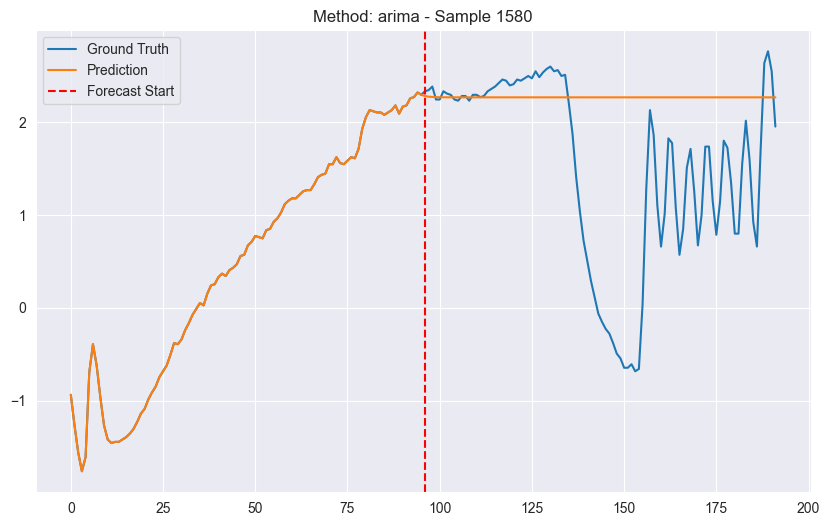

Method: arima
MSE: 1.7947, MAE: 0.7842, RMSE: 1.3397, MAPE: 1.5719, MSPE: 328.3672


In [3]:
# Define the statistical methods to compare
methods = ['naive_last', 'naive_mean', 'naive_seasonal', 'drift', 'arima']
methods = ['arima']

# Dictionary to store results
results = {}

# Loop through each method
for method in methods:
    print(f"\n\n{'='*50}")
    print(f"Testing Statistical Method: {method}")
    print(f"{'='*50}")
    
    # Update the configuration for this method
    args.stat_method = method
    
    # Set ARIMA parameters if using ARIMA
    if method == 'arima':
        args.arima_order = [1, 1, 0]  # Default ARIMA(1,1,0)
        print(f"ARIMA Parameters (p,d,q): {args.arima_order}")
    
    # Create experiment
    exp = Exp_Main(args)
    
    # Get data
    print("Loading data...")
    test_data, test_loader = exp._get_data(flag='test')
    print(f"Test data shape: {test_data.data_x.shape}, Test loader length: {len(test_loader)}")
    
    # Test the model
    print("Testing model...")
    exp.model.eval()
    
    # Initialize lists to store predictions and ground truth
    preds = []
    trues = []
    
    # Test without training (statistical models don't need training)
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_x, batch_y, batch_x_mark, batch_y_mark = [
                tensor.float().to(exp.device) for tensor in batch
            ]
            
            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp.device)
            
            # Forward pass
            outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            
            f_dim = -1 if args.features == 'MS' else 0
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(exp.device)
            
            pred = outputs.detach().cpu().numpy()
            true = batch_y.detach().cpu().numpy()
            
            preds.append(pred)
            trues.append(true)
            
            # Visualize a few examples
            if i % 20 == 0:
                input_data = batch_x.detach().cpu().numpy()
                gt = np.concatenate((input_data[0, :, -1], true[0, :, -1]), axis=0)
                pd = np.concatenate((input_data[0, :, -1], pred[0, :, -1]), axis=0)
                
                plt.figure(figsize=(10, 6))
                plt.plot(gt, label='Ground Truth')
                plt.plot(pd, label='Prediction')
                plt.axvline(x=args.seq_len, color='r', linestyle='--', label='Forecast Start')
                plt.legend()
                plt.title(f'Method: {method} - Sample {i}')
                plt.show()
    
    # Concatenate all predictions and ground truth
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Reshape for metric calculation
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    
    # Calculate metrics
    mae, mse, rmse, mape, mspe = metric(preds, trues)
    print(f'Method: {method}')
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, MSPE: {mspe:.4f}')
    
    # Store results
    results[method] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'mspe': mspe
    }


## 5. Comparing Results

Let's compare the results of different statistical methods.


In [6]:
results

{'arima': {'mae': np.float32(0.7841718),
  'mse': np.float32(1.794716),
  'rmse': np.float32(1.3396701),
  'mape': np.float32(1.571927),
  'mspe': np.float32(328.36722)}}

In [ ]:
# Create a DataFrame to compare results
results_df = pd.DataFrame(results).T
print("Comparison of Statistical Methods:")
results_df


In [ ]:
# Visualize the comparison
metrics = ['mae', 'mse', 'rmse', 'mape', 'mspe']

plt.figure(figsize=(15, 10))
for i, metric_name in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results_df.index, results_df[metric_name])
    plt.title(f'Comparison of {metric_name.upper()}')
    plt.xticks(rotation=45)
    plt.ylabel(metric_name.upper())
plt.tight_layout()
plt.show()


## 6. Detailed Analysis of ARIMA Results

Let's take a closer look at the ARIMA results and try different parameter settings.


In [ ]:
# Test different ARIMA parameters
arima_params = [
    (1, 0, 0),  # AR(1)
    (0, 1, 0),  # I(1)
    (0, 0, 1),  # MA(1)
    (1, 1, 0),  # ARIMA(1,1,0)
    (0, 1, 1),  # ARIMA(0,1,1)
    (1, 1, 1),  # ARIMA(1,1,1)
    (2, 1, 0),  # ARIMA(2,1,0)
    (1, 1, 2)   # ARIMA(1,1,2)
]

arima_results = {}

for p, d, q in arima_params:
    param_name = f"ARIMA({p},{d},{q})"
    print(f"\n\n{'='*50}")
    print(f"Testing {param_name}")
    print(f"{'='*50}")
    
    # Update the configuration for this method
    args.stat_method = 'arima'
    args.arima_order = [p, d, q]
    
    # Create experiment
    exp = Exp_Main(args)
    
    # Get data
    test_data, test_loader = exp._get_data(flag='test')
    
    # Test the model
    exp.model.eval()
    
    # Initialize lists to store predictions and ground truth
    preds = []
    trues = []
    
    # Test without training (statistical models don't need training)
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i > 5:  # Limit to a few batches for speed
                break
                
            batch_x, batch_y, batch_x_mark, batch_y_mark = [
                tensor.float().to(exp.device) for tensor in batch
            ]
            
            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp.device)
            
            # Forward pass
            outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            
            f_dim = -1 if args.features == 'MS' else 0
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(exp.device)
            
            pred = outputs.detach().cpu().numpy()
            true = batch_y.detach().cpu().numpy()
            
            preds.append(pred)
            trues.append(true)
    
    # Concatenate all predictions and ground truth
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Reshape for metric calculation
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    
    # Calculate metrics
    mae, mse, rmse, mape, mspe = metric(preds, trues)
    print(f'Method: {param_name}')
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, MSPE: {mspe:.4f}')
    
    # Store results
    arima_results[param_name] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'mspe': mspe
    }
